## Load packages

In [2]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import glob
import json
import pickle as p
from math import nan
from sklearn.isotonic import IsotonicRegression
import datetime
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import os
import csv

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (30,16)
plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'figure.autolayout': True})


import warnings
warnings.filterwarnings('ignore')


## Load data

In [4]:
path = "C:/Users/Hamidreza/Dropbox/UAS4T/competition_dataset/"
# load samaple data
meta_dfs = []
trace_dfs = []

with open(path+'pneuma_competition_dataset.p', 'rb') as f:
    meta_df, trace_df = p.load(f)

# lead the information about the streets
street_df = pd.read_csv('street_information.csv',header=0)
# load the information about traces
trace_df = pd.read_csv('traces_road.csv',header=0)
# covert time from string to datetime 
trace_df['time'] = pd.to_datetime(trace_df['time'])

In [5]:
# transforming (lat,lon) to (x,y) coordinates
# transfomration are from https://en.wikipedia.org/wiki/Geographic_coordinate_system
# x = longitude * lon_to_x - offset_x
# y = latitude * lat_to_y - offset_y
phi = trace_df['lat'].mean()
lat_to_y = 111132.92 - 559.82 * np.cos(2*phi) + 1.175 * np.cos(4*phi) - 0.0023 * np.cos(6*phi)
lon_to_x = 111412.84 * np.cos(phi) - 93.5 * np.cos(3*phi) + 0.118 * np.cos(5*phi)
offset_X = (trace_df['lon'] * lon_to_x).min()
offset_Y = (trace_df['lat'] * lat_to_y).min()

In [6]:
# determine the track_id for each vehicle type
motors = meta_df[meta_df['type'] == ' Motorcycle']['track_id'].as_matrix()
cars = meta_df[meta_df['type'] == ' Car']['track_id'].as_matrix()
mediums = meta_df[meta_df['type'] == ' Medium Vehicle']['track_id'].as_matrix()
heavy = meta_df[meta_df['type'] == ' Heavy Vehicle']['track_id'].as_matrix()
bus = meta_df[meta_df['type'] == ' Bus']['track_id'].as_matrix()
taxi = meta_df[meta_df['type'] == ' Taxi']['track_id'].as_matrix()

## Functions

In [7]:
def intersections_transform (intersections, heading):
    # takes (lat,lon) coordinates of intersetcions and the heading of the road; returns the location of each intersection along the road 
    # transform from (lat,lon) coordinates to (x,y) coordinates
    intersections = [(_[1]*lon_to_x - offset_X, _[0]*lat_to_y - offset_Y) for _ in intersections]
    # form the rotation matrix/transformation to project onto the road
    R = np.array([[np.cos(-heading), -np.sin(-heading)],[np.sin(-heading), np.cos(-heading)]])
    # find the projection of intersection information 
    intersections = [np.dot(R.squeeze(),list(_))-[street_df.loc[0,'X_1_r'],0] for _ in intersections]
    # only keep X coordinates of intresection (their locatino along the road)
    intersections = np.array([_[0] for _ in intersections])   
    return intersections

In [190]:
def select_stopped_vehicles (road, dir = None, min_speed = 10):
    # select all vehicles that can be potentially part of a queue

    # minimum speed to be still considered as (potentially) being part of a queue
    # default values: min_speed = 10 #km/hr
    stopped_df = trace_df[trace_df['speed']<=min_speed]
    # only keep the cars that are on WB Alexandras
    stopped_df = stopped_df[stopped_df['road'] == road]
    if dir != None:
        stopped_df = stopped_df[stopped_df['dir'] == dir]
    stopped_df = stopped_df.sort_values(['time','X_road'])
    
    # remove motorcycles
    #stopped_df = stopped_df[~stopped_df['track_id'].isin(motors)]

    # remove temporarily parked cars
    # to do so we track how long each vehicle remains still in one location, 
    # if it remains still for longer than 180 seconds (which is three times the cycle length), then we flag it as a temporarily parked car  
    # the code below provide a vectorized implementation of the above approach
    parked_df = stopped_df.sort_values(['track_id','time'])
    # flag the cars that move more than 1 (meter) per frame
    parked_df['moving'] = (parked_df['X_road'].diff()>1).astype(int)
    # determine where in the calculation of 'moving' column, we used X_road from two different vehicles
    # such a comparsion is not valid, and we should not consider it
    parked_df['new_id'] = (parked_df['track_id'].diff()!=0).astype(int)
    # 'move_ct' column will increase as long as the vehicles moves or we swtich to a new vehicle as we search through dataset
    parked_df['move_ct'] = parked_df['moving'].cumsum() + parked_df['new_id'].cumsum()   
    # for each subset of dataset where a vehicle remains still, we select the begining and the end data points for that subset
    parked_df = pd.concat([
        parked_df.drop_duplicates(['move_ct'],keep='first'),
        parked_df.drop_duplicates(['move_ct'],keep='last')]).sort_values(['track_id','time'])
    # determine the time length for each interval that a vehicle is still
    parked_df['park_time'] = parked_df['time'].diff().dt.total_seconds() 
    # set 'park_time' to 0 for the end of each interval (the time difference between the and of an interval and the begining of the next interval is not valid)
    parked_df.loc[parked_df['move_ct'].diff()>0, 'park_time'] = 0 
    # select the intervals where the time length is longer than 279seconds
    parked_df = parked_df[parked_df['park_time']>270]
    # filter out the vehicles that are identified as temporarily parked cars 
    stopped_df = stopped_df[~(stopped_df['track_id'].isin(parked_df['track_id'].as_matrix()))]
    return stopped_df

In [9]:
def wave_time_delay (stopped_df, wave_speed = 17):
    # determine (time,location) pairs that corrosponds to the same wave of stopped cars propagating toward the intersection upstreatm
    # assuming the wave propagation speed of 15 km/hr
    # the equivalent time (tau) is calculated by time-shifting the original time stamp based on how far each vehicle is from the main intersection (X_road)
    # so, the vehicles that have identical tau, (potentially) belongs to the same wave
    # defult values: wave_speed = 17 #km/hr
    # calculate the frame number (25 frames per seconds, 40 ms each) from 'time' column
    stopped_df['tau'] = ((stopped_df['time']-pd.to_datetime('2020-08-04 08:00:00')).dt.total_seconds()/(0.040)).astype(int)
    # time-shifting according to wave_speed and X_road
    stopped_df['tau'] -= ((stopped_df['X_road']/(wave_speed/3.6))//0.040)
    # determine the timestamp associated with tau which can be handy for visualizations
    stopped_df['time_tau'] = pd.to_timedelta(stopped_df['tau'].astype(float)*0.04,unit='S')+pd.to_datetime('2020-08-04 08:00:00')
    # reduce the time resolution from 40 ms to 1 seconds; the calculated values for tau are not necessarilly 40 ms aparts
    # so the lower resolution helps making sure that for every second there exists a data point)
    stopped_df['tau'] = stopped_df['tau']//25
    
    return stopped_df

In [184]:
def find_max_Q(stopped_df):
    # find max queues and related information
    
    
    # sort the data according to time, lane, and location
    stopped_df.sort_values(by=['tau','lane','X_road'],inplace=True)
    stopped_df.drop_duplicates(['track_id','tau'],inplace=True)
    stopped_df.reset_index(inplace=True,drop=True)
    # create 'index' column which later will be used to count #cars in queues
    stopped_df['index'] = stopped_df.index
    # calculate difference in X_road for consequetive stopped cars
    stopped_df['dx'] = stopped_df['X_road'].diff()
    # set 'dx' = 0 that are calculated from cars that do not belong to the same lane 
    stopped_df.loc[stopped_df['lane'].diff()!=0,'dx'] = np.nan
    # set 'dx' = 0 that are calculated from cars that do not belong to the same wave (equal 'tau') 
    stopped_df.loc[stopped_df['tau'].diff()!=0,'dx'] = np.nan

    # create a new column that contains the type of each vehicle
    stopped_df['type'] = np.nan
    stopped_df.loc[stopped_df['track_id'].isin(motors),'type'] = 'motor'
    stopped_df.loc[stopped_df['track_id'].isin(cars),'type'] = 'car'
    stopped_df.loc[stopped_df['track_id'].isin(taxi),'type'] = 'taxi'
    stopped_df.loc[stopped_df['track_id'].isin(mediums),'type'] = 'medium'
    stopped_df.loc[stopped_df['track_id'].isin(heavy),'type'] = 'heavy'
    stopped_df.loc[stopped_df['track_id'].isin(bus),'type'] = 'bus'

    # determine the maximum allowable gap based on the type of the vehicle in the front
    stopped_df['max_gap'] = np.nan
    stopped_df.loc[stopped_df['track_id'].shift(1).isin(motors),'max_gap'] = 12
    stopped_df.loc[stopped_df['track_id'].shift(1).isin(cars),'max_gap'] = 18
    stopped_df.loc[stopped_df['track_id'].shift(1).isin(taxi),'max_gap'] = 18
    stopped_df.loc[stopped_df['track_id'].shift(1).isin(mediums),'max_gap'] = 20
    stopped_df.loc[stopped_df['track_id'].shift(1).isin(heavy),'max_gap'] = 25
    stopped_df.loc[stopped_df['track_id'].shift(1).isin(bus),'max_gap'] = 25

    # determine the start of the Queue (position and index of the car)
    stopped_df ['Q_start'] = np.nan
    stopped_df ['Q_start_ind'] = np.nan
    # a car is located in the front of the queue if its distance to the front of the queue > 'max_gap'
    stopped_df.loc[(stopped_df['dx'].isna())|(stopped_df['dx']>stopped_df['max_gap']),'Q_start'] = stopped_df.loc[(stopped_df['dx'].isna())|(stopped_df['dx']>stopped_df['max_gap']),'X_road']
    stopped_df.loc[(stopped_df['dx'].isna())|(stopped_df['dx']>stopped_df['max_gap']),'Q_start_ind'] = stopped_df.loc[(stopped_df['dx'].isna())|(stopped_df['dx']>stopped_df['max_gap']),'index']

    # for each vehicle in a queue that is not at the front of it, determine location and the index of the frst car in the queue 
    stopped_df['Q_start'] = stopped_df['Q_start'].fillna(method='ffill')
    stopped_df['Q_start_ind'] = stopped_df['Q_start_ind'].fillna(method='ffill')

    # determine the length of the queue (in meters and #cars)
    stopped_df['Q_len'] = stopped_df['X_road'] - stopped_df['Q_start']
    stopped_df['Q_len_car'] = stopped_df['index'] - stopped_df['Q_start_ind']

    # find the chain of cars (with equal tau) that creates the longest queue
    max_row = stopped_df.loc[stopped_df['Q_len'].argmax()]
    print('(i) queue length = {0:.2f} meters, {1} #vehicles'.format(max_row['Q_len'],max_row['Q_len_car']))
    print('(ii) forms in lane = {0}'.format(max_row['lane']))
    print('(iii) coordinates: from ({0:.6f},{1:.6f}) to ({2:.6f},{3:.6f})'.format(stopped_df.loc[max_row['Q_start_ind'],'lat'], 
                                                                                  stopped_df.loc[max_row['Q_start_ind'],'lon'], max_row['lat'], max_row['lon']))
    print('(iv) max queue occurs at {0}'.format(max_row['time'].strftime("%M:%S")))
    starting_intersection_index = np.argmin(np.abs(intersections[1::2]-max_row['Q_start']))
    ending_intersection_index = starting_intersection_index + np.argwhere((intersections[2*starting_intersection_index+1::2]-max_row['X_road'])<0)[-1]
    if starting_intersection_index == ending_intersection_index:
        print('(v) no spillback, queue starts behind intersection of "{0}"'.format(intersections_name[starting_intersection_index]))
    else:
        print('(v) spillback occurs, queue starts behind intersection with "{0}"'.format(intersections_name[starting_intersection_index]))
        for i in np.arange(starting_intersection_index+1, ending_intersection_index+1):
            spillback_first_car_id = stopped_df.loc[max_row['Q_start_ind']:max_row['index']][stopped_df.loc[max_row['Q_start_ind']:max_row['index']]['X_road']>intersections[2*i+1]].iloc[0]['track_id']
            spillback_first_car = stopped_df[stopped_df['track_id'] == spillback_first_car_id]
            #spillback_first_car = spillback_first_car[(spillback_first_car['tau']<max_row['tau'])&(spillback_first_car['tau']>(max_row['tau']-90))]
            print('    spillback occurs at intersection with "{0}" at time {1}'.format(intersections_name[i],spillback_first_car.iloc[0]['time'].strftime("%M:%S")))
    return stopped_df

In [62]:
def plot_queues (stopped_df, intersections, intersections_name, corridor_name, timing, red_phase, use_tau = False, reverse_y = False, lane_set = [1,2,3,4]):
    # visualize the result, plot the queues with appropriate time-shifting 
    if use_tau:
        t_column = 'time_tau'
    else:
        t_column = 'time'
            
    for lane in lane_set:
        plt.figure()
        plt.plot(stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(motors)),t_column],stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(motors)),'X_road'],'o',lw=3,markersize = 5,color='darkorange', label = 'Motorcycle')
        plt.plot(stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(cars)),t_column],stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(cars)),'X_road'],'o',lw=3,markersize = 5,color='blue',label = 'Car')
        plt.plot(stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(taxi)),t_column],stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(taxi)),'X_road'],'o',lw=3,markersize = 5,color='yellow',label = 'Taxi')
        plt.plot(stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(mediums)),t_column],stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(mediums)),'X_road'],'o',lw=3,markersize = 5,color='purple',label = 'Medium Vehicle')
        plt.plot(stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(heavy)),t_column],stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(heavy)),'X_road'],'o',lw=3,markersize = 5,color='darkgreen',label='Heavy Vehicle')
        plt.plot(stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(bus)),t_column],stopped_df.loc[(stopped_df['lane'] == lane)&(stopped_df['track_id'].isin(bus)),'X_road'],'o',lw=3,markersize = 5,color='red',label='Bus')

        for _ in (intersections):
            plt.hlines(_,stopped_df.iloc[0]['time'],stopped_df.iloc[-1]['time'],lw=5)
        plt.hlines(intersections[0],stopped_df.iloc[0]['time'],stopped_df.iloc[-1]['time'],lw=5,label = 'intersection box')
        if reverse_y:
            plt.gca().invert_yaxis()


        for j in np.arange(0,2*(len(timing)),2):
            ref_time = timing[int(j/2)]
            if ref_time == None:
                continue
            for i in range(9):
                if (i==0)&(j==0):
                    red_time = ref_time + pd.Timedelta(90 * i,'S') 
                    plt.vlines(red_time,intersections[j],intersections[j+2],color='red',lw=5, label = 'start of red phase')
                    green_time = ref_time + pd.Timedelta(red_phase[int(j/2)],'S')+ pd.Timedelta(90 * i,'S') 
                    plt.vlines(green_time,intersections[j],intersections[j+2],color='green',lw=5,  label = 'start of red green')
                    plt.fill_betweenx([intersections[j],intersections[j+2]],[red_time,red_time],[green_time,green_time], color='red',alpha=0.3, label = 'WB red phase')
                    plt.fill_betweenx([intersections[j],intersections[j+2]],[green_time,green_time],[red_time+pd.Timedelta(90,'S'),red_time+pd.Timedelta(90,'S')], color='green',alpha=0.3,label = 'WB green phase')
                else:
                    red_time = ref_time + pd.Timedelta(90 * i,'S') 
                    plt.vlines(red_time,intersections[j],intersections[j+2],color='red',lw=5)
                    green_time = ref_time + pd.Timedelta(red_phase[int(j/2)],'S')+ pd.Timedelta(90 * i,'S') 
                    plt.vlines(green_time,intersections[j],intersections[j+2],color='green',lw=5)
                    plt.fill_betweenx([intersections[j],intersections[j+2]],[red_time,red_time],[green_time,green_time], color='red',alpha=0.3)
                    plt.fill_betweenx([intersections[j],intersections[j+2]],[green_time,green_time],[red_time+pd.Timedelta(90,'S'),red_time+pd.Timedelta(90,'S')], color='green',alpha=0.3)
        plt.ylabel('meters')
        plt.title(' {0} - Lane {1}'.format(corridor_name, lane))
        plt.xlabel('minutes after 8:00 AM')
        plt.legend(loc = 'lower left')
        if reverse_y:
            text_pos = (intersections[1::2]+intersections[:-1:2])/2
        else:
            text_pos = (intersections[::2]+intersections[1::2])/2
        for i in range(len(intersections_name)):
            if reverse_y:
                plt.text('2020-08-04 08:14:00',text_pos[i]+5,intersections_name[i])
            else:
                plt.text('2020-08-04 08:14:00',text_pos[i]-5,intersections_name[i])
                
        plt.xlim('2020-08-04 07:59:00','2020-08-04 08:17:00');
        #plt.ylim(700,-50)
        plt.xticks(['2020-08-04 08:00:00','2020-08-04 08:01:00','2020-08-04 08:02:00','2020-08-04 08:03:00','2020-08-04 08:04:00','2020-08-04 08:05:00','2020-08-04 08:06:00','2020-08-04 08:07:00'
                   ,'2020-08-04 08:08:00','2020-08-04 08:09:00','2020-08-04 08:10:00','2020-08-04 08:11:00','2020-08-04 08:12:00','2020-08-04 08:13:00','2020-08-04 08:14:00']
                  ,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        plt.grid(True,linewidth=2)


## WB Alexandras

(i) queue length = 284.71 meters, 33.0 #vehicles
(ii) forms in lane = 2.0
(iii) coordinates: from (37.991626,23.732484) to (37.991210,23.735119)
(iv) max queue occurs at 09:43
(v) spillback occurs, queue starts behind intersection with "Mavrommateon"
    spillback occurs at intersection with "Mpoumpoulinas" at time 09:16


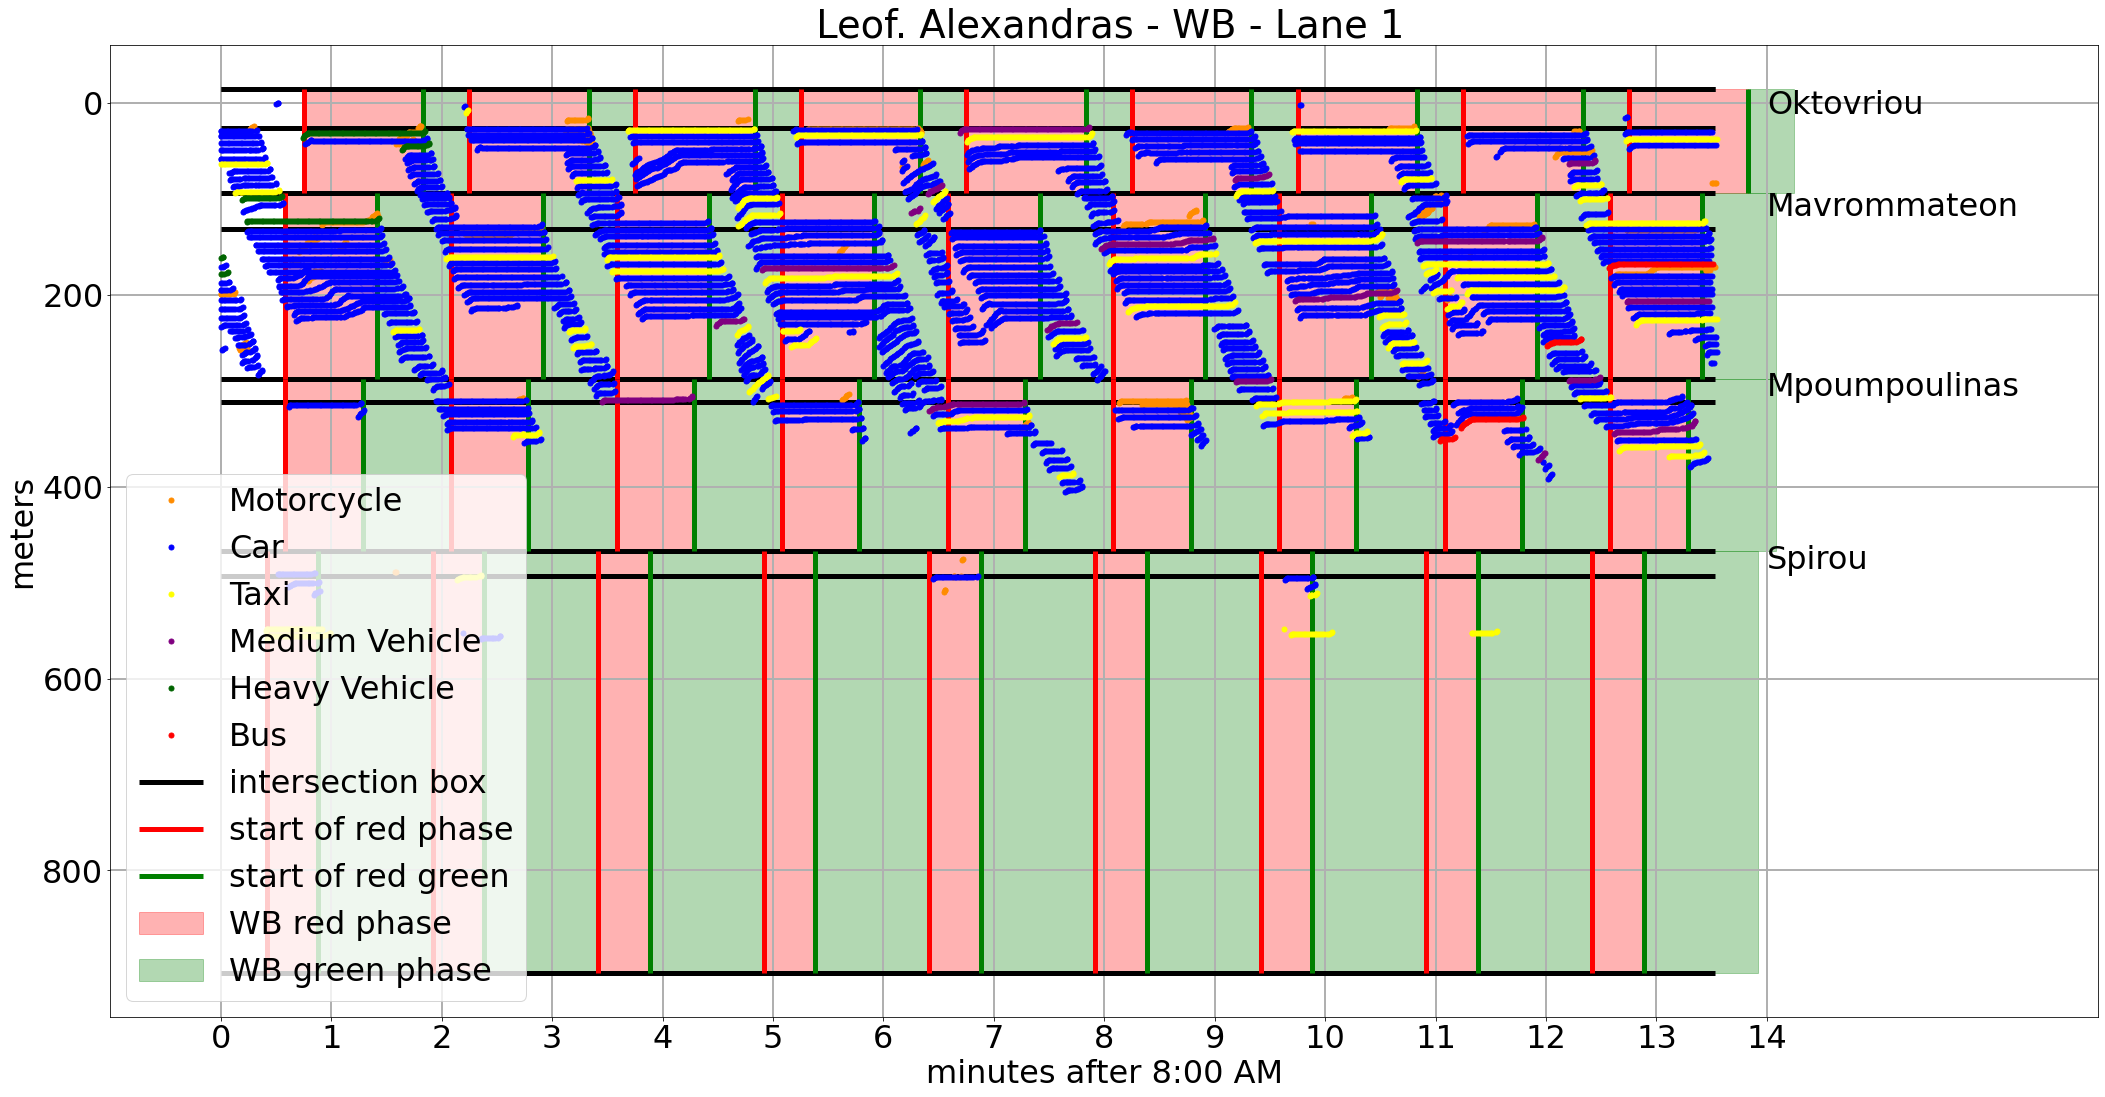

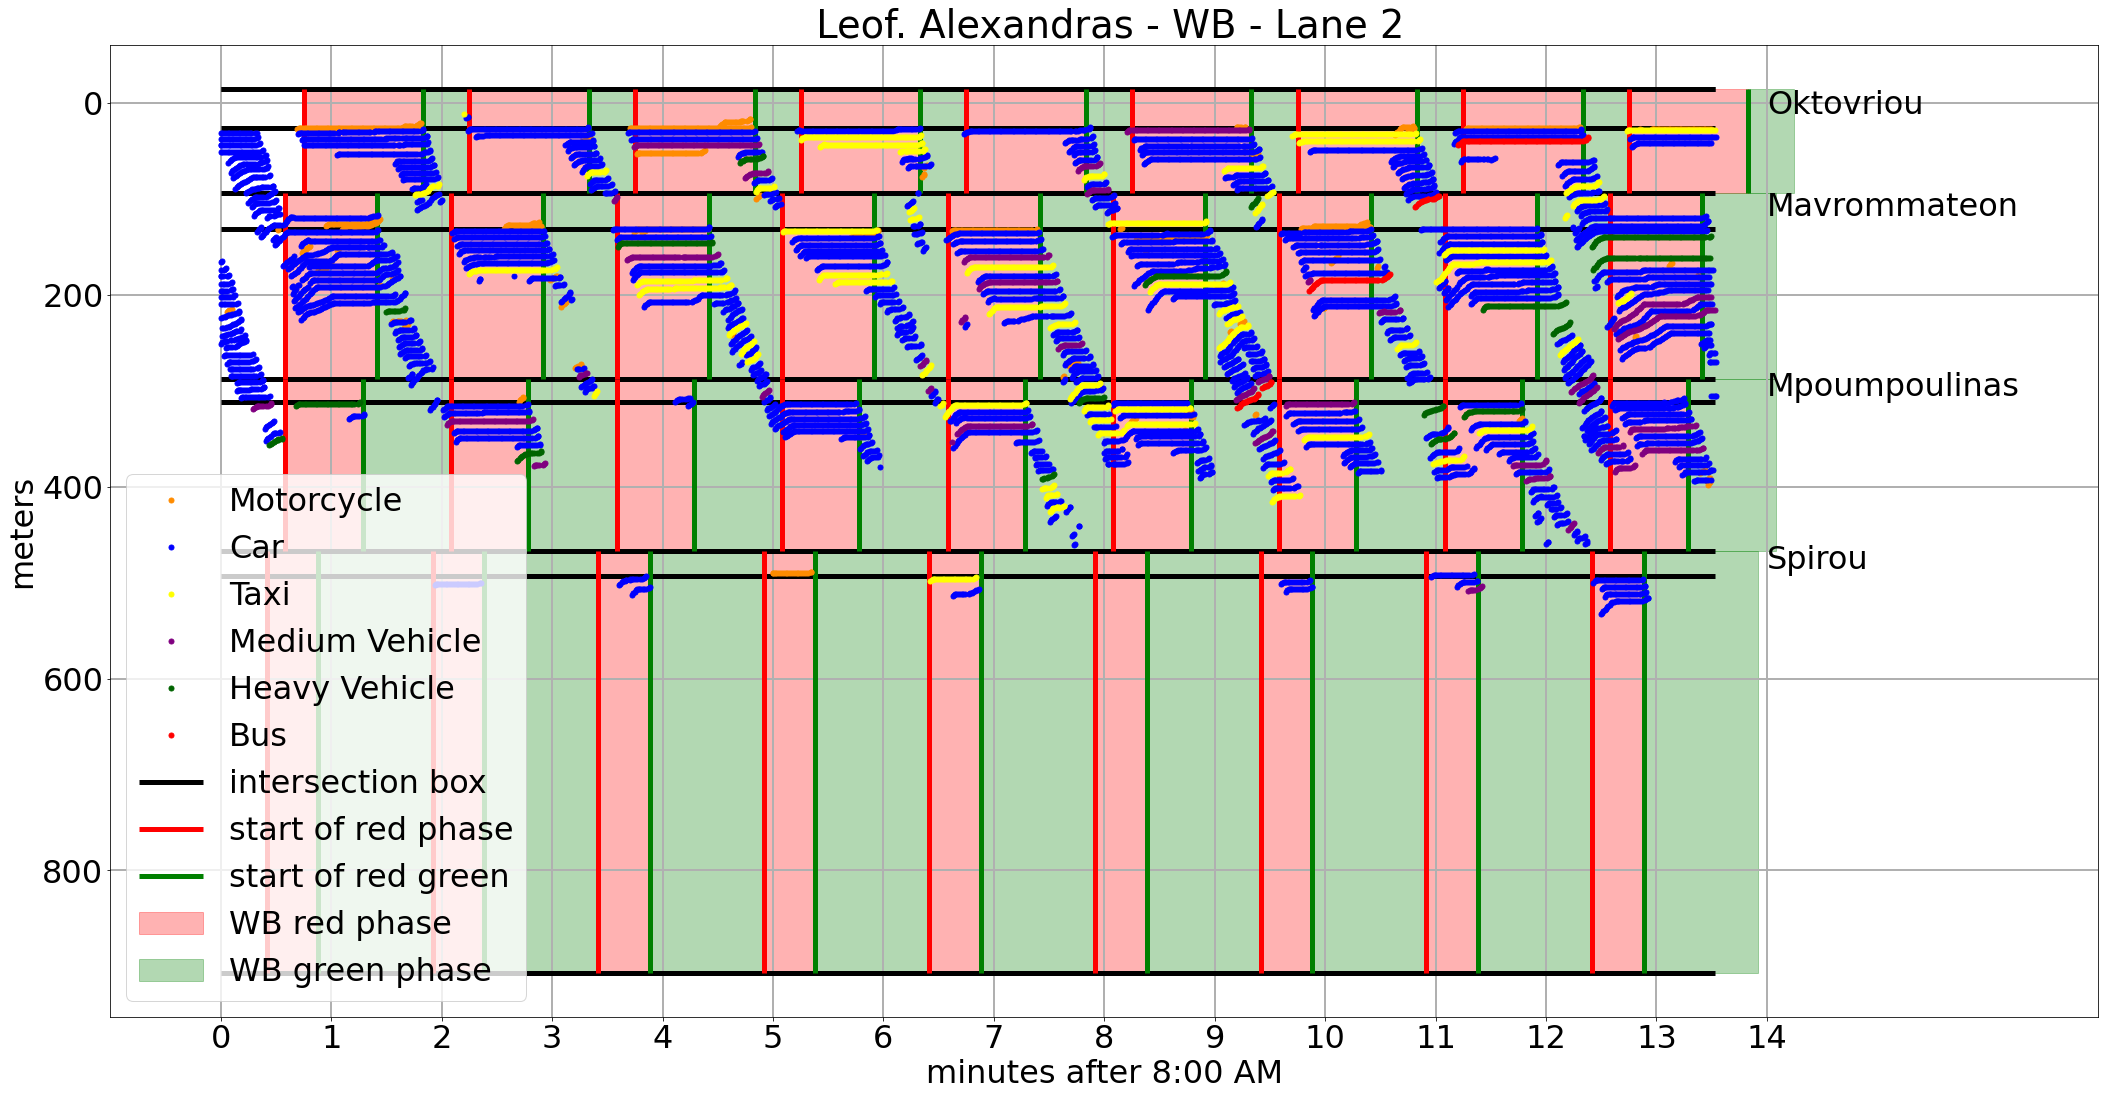

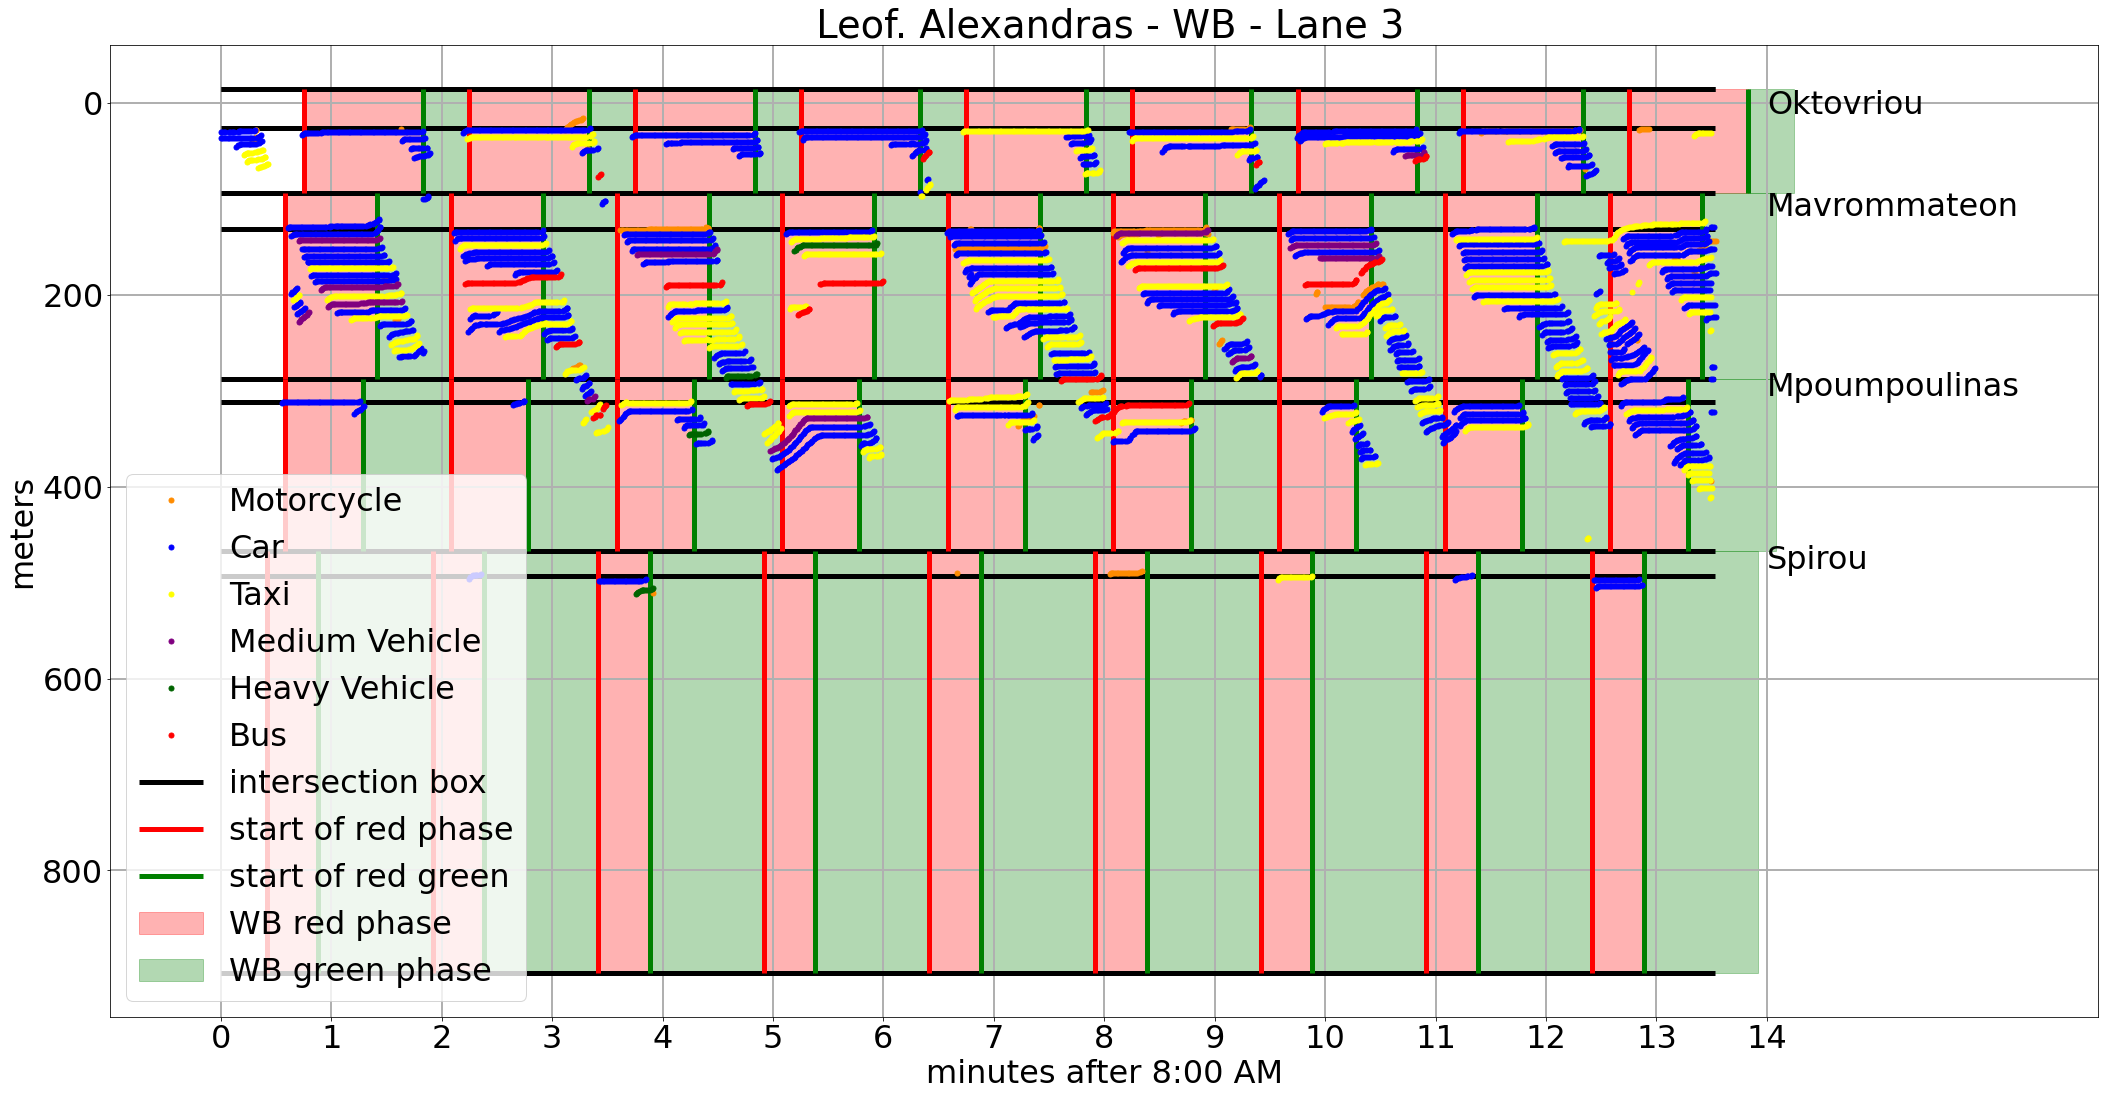

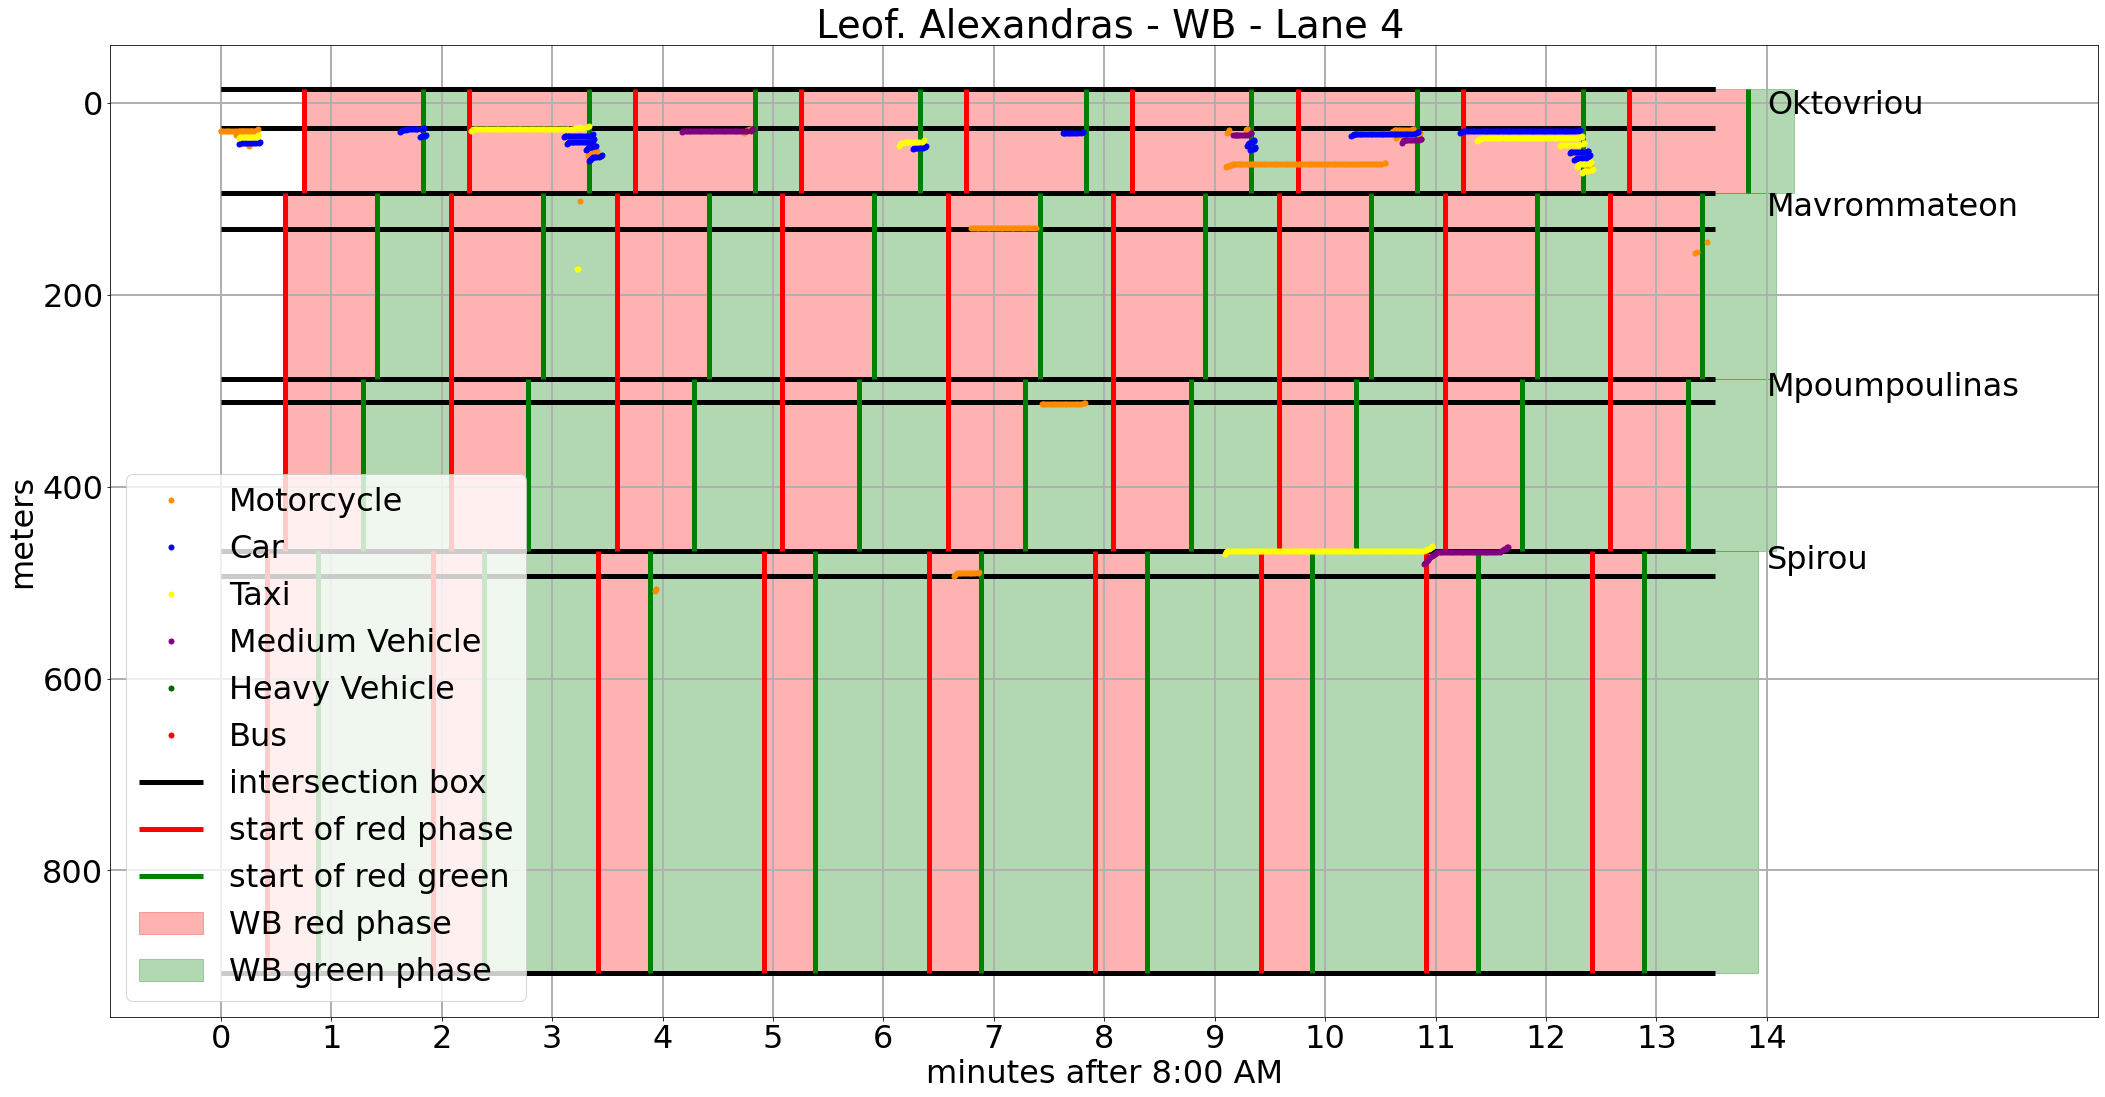

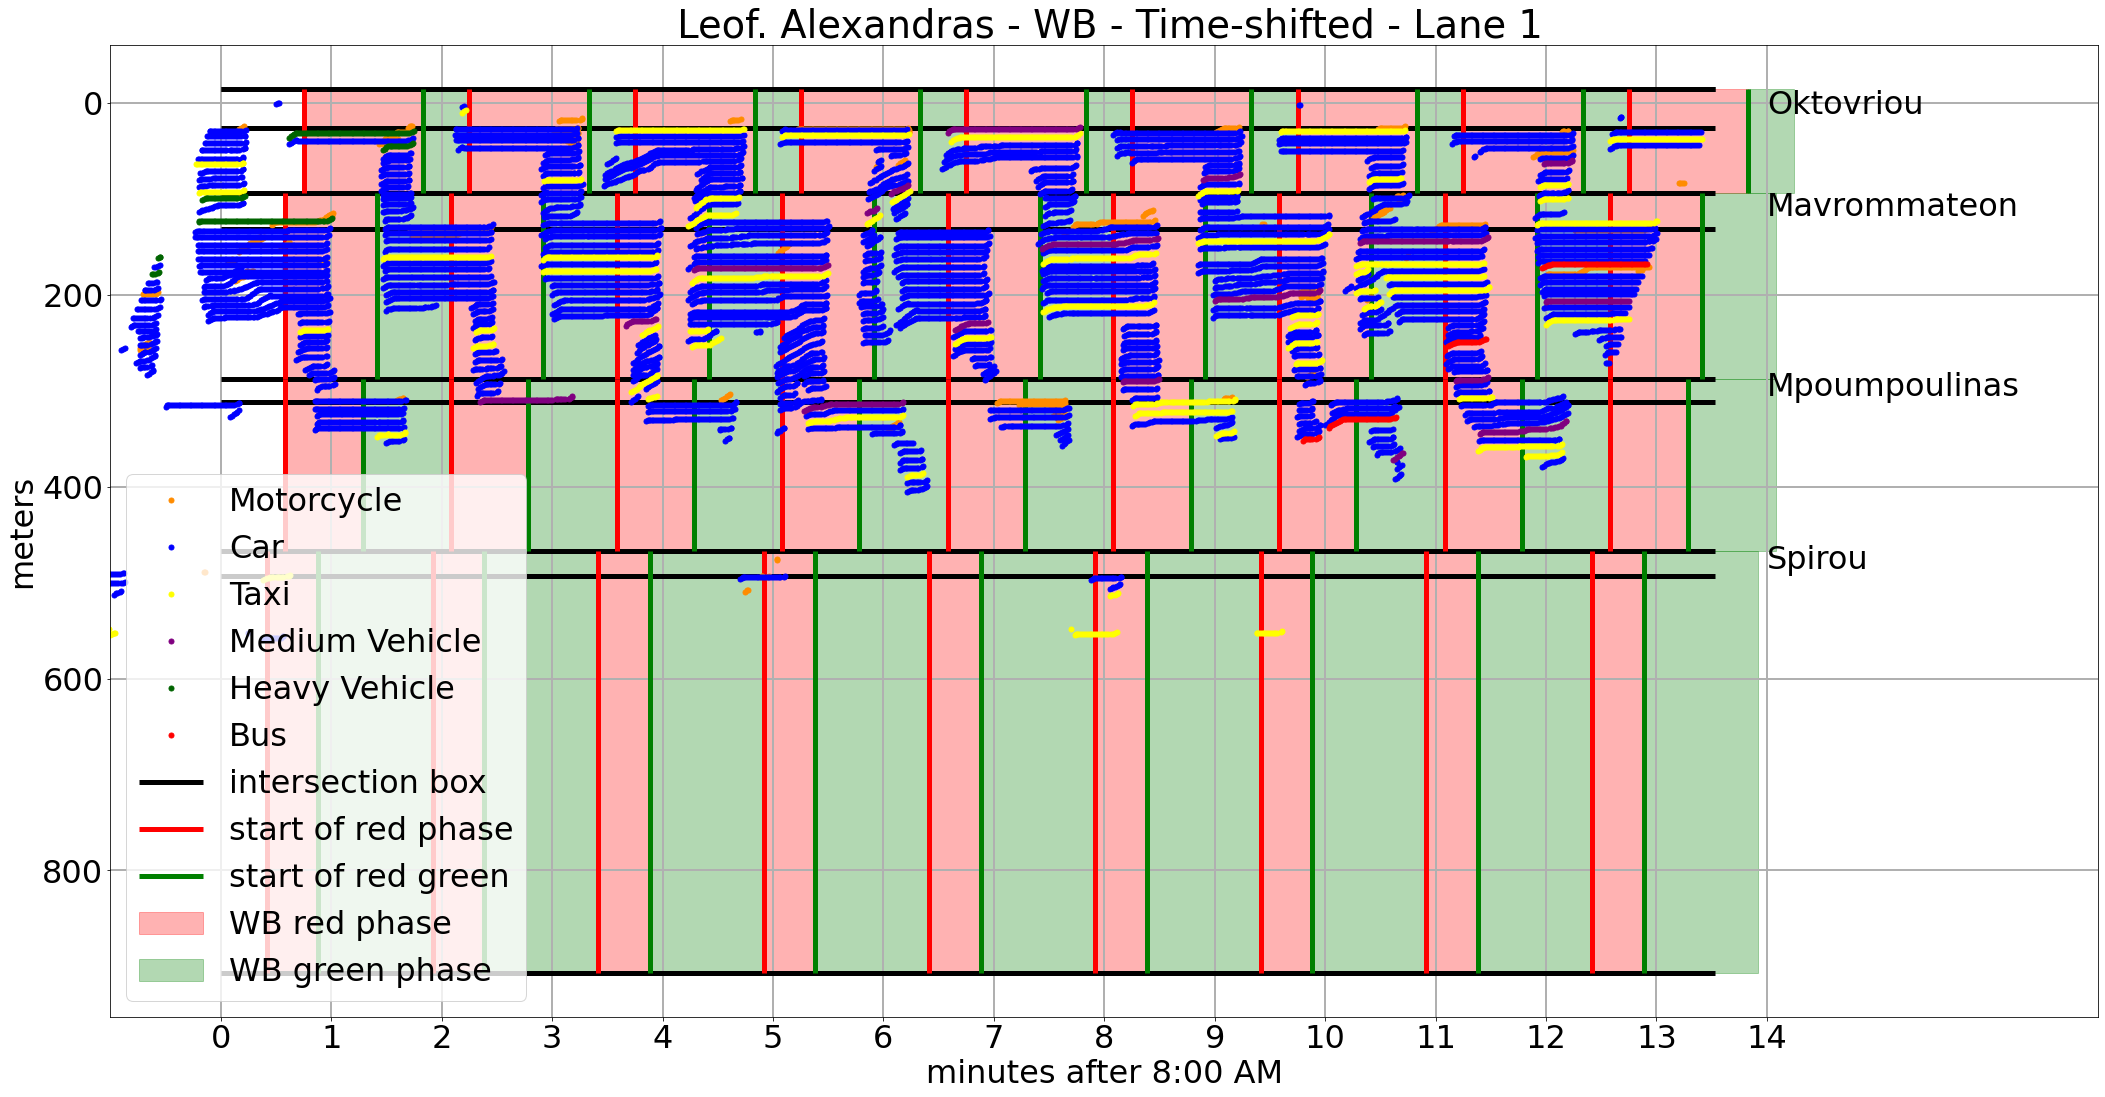

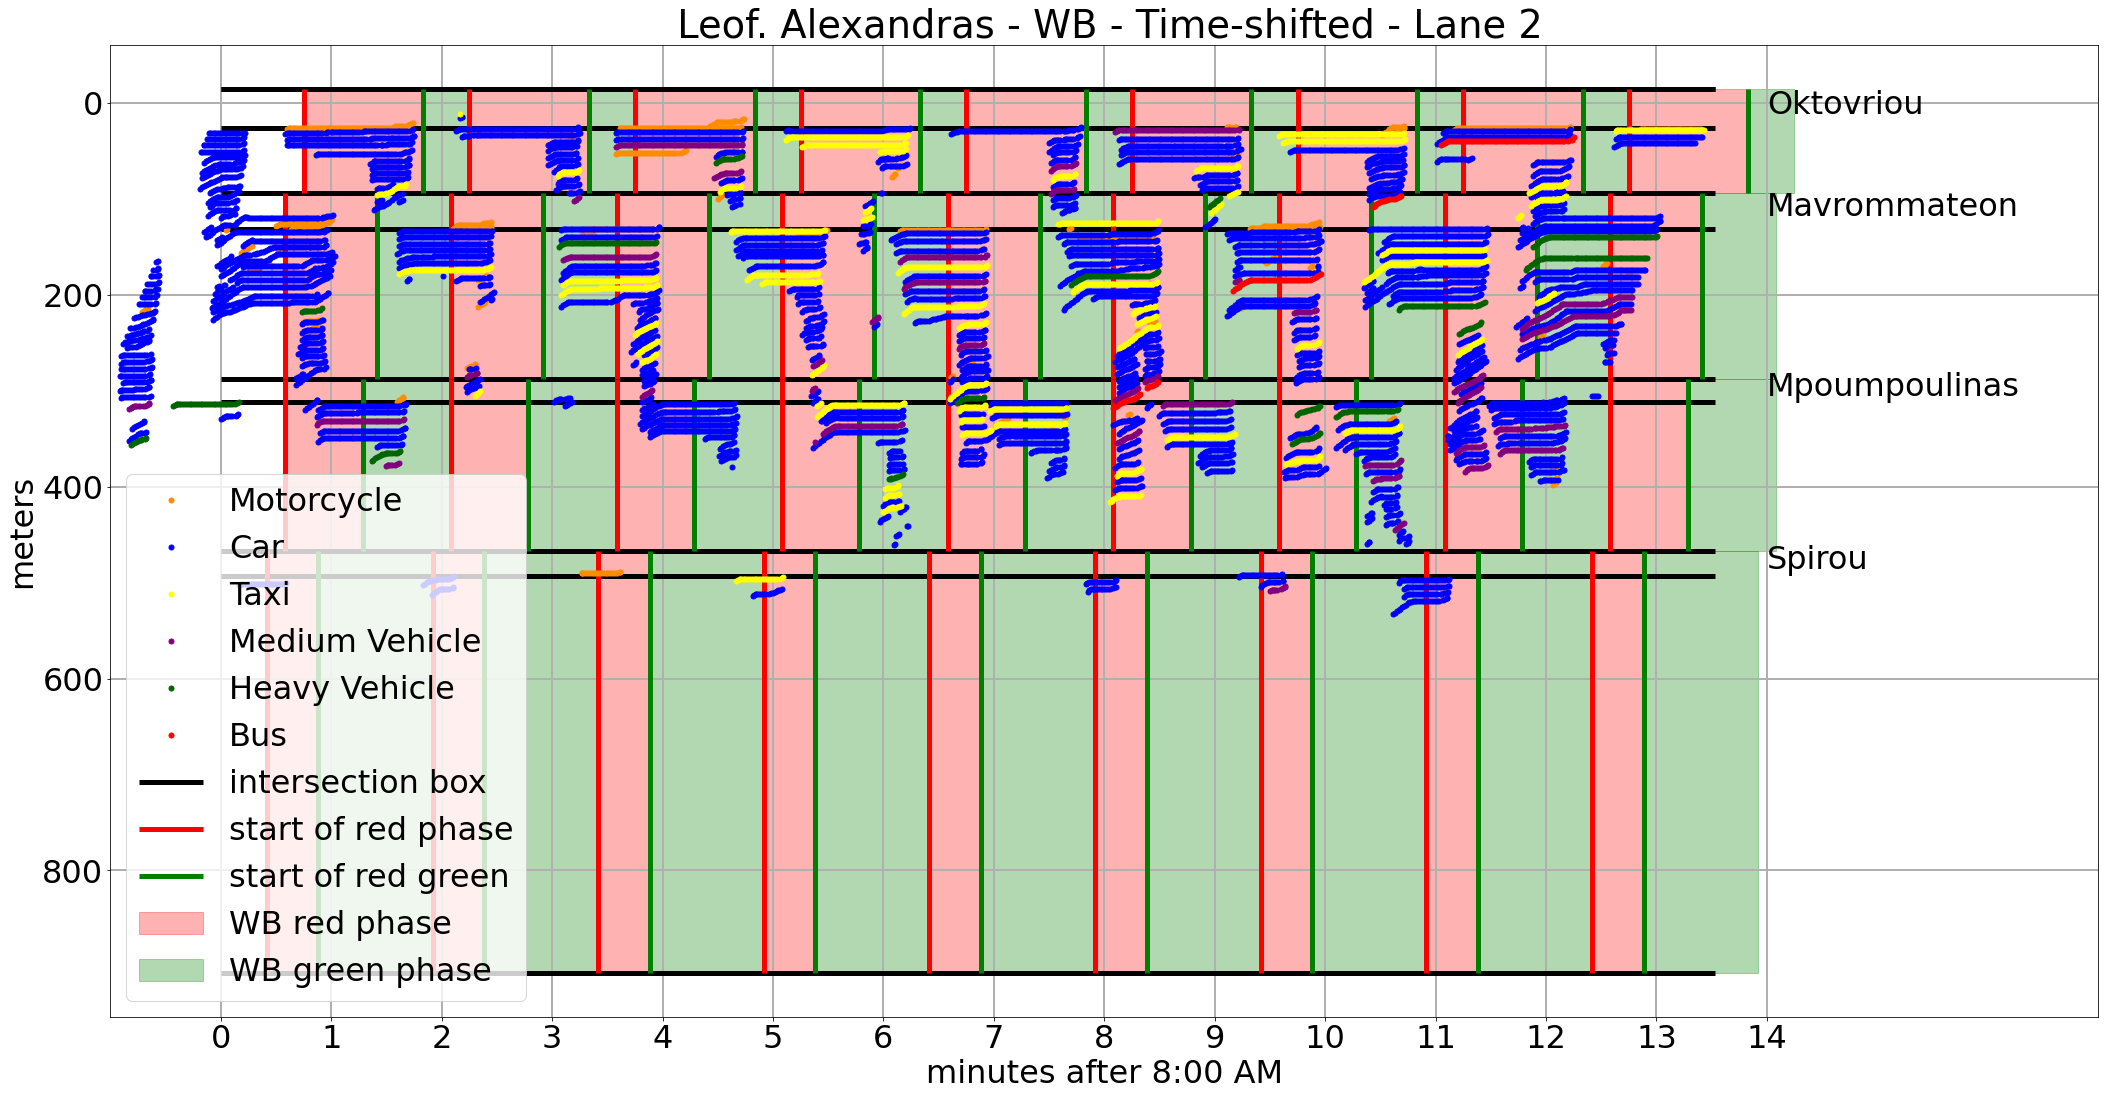

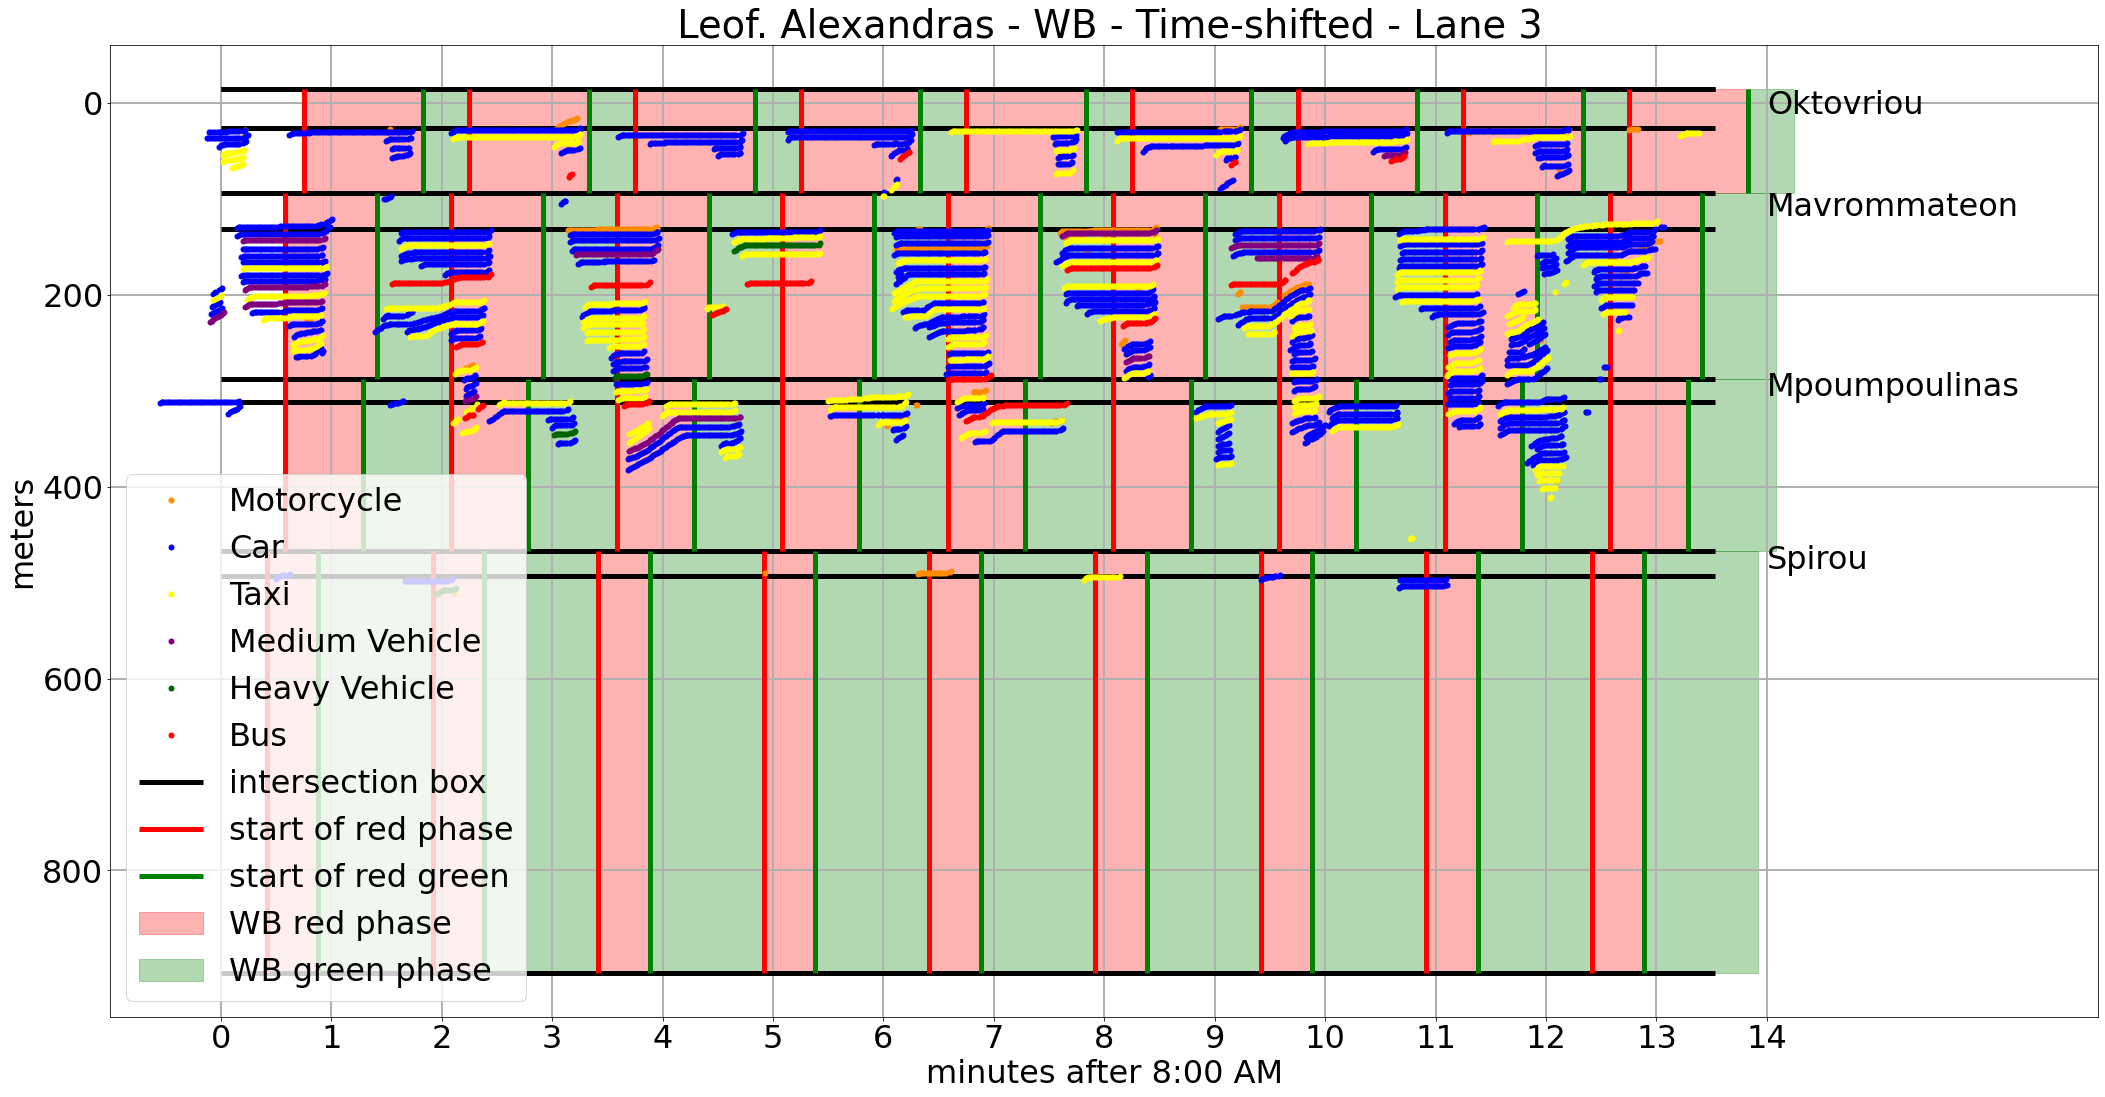

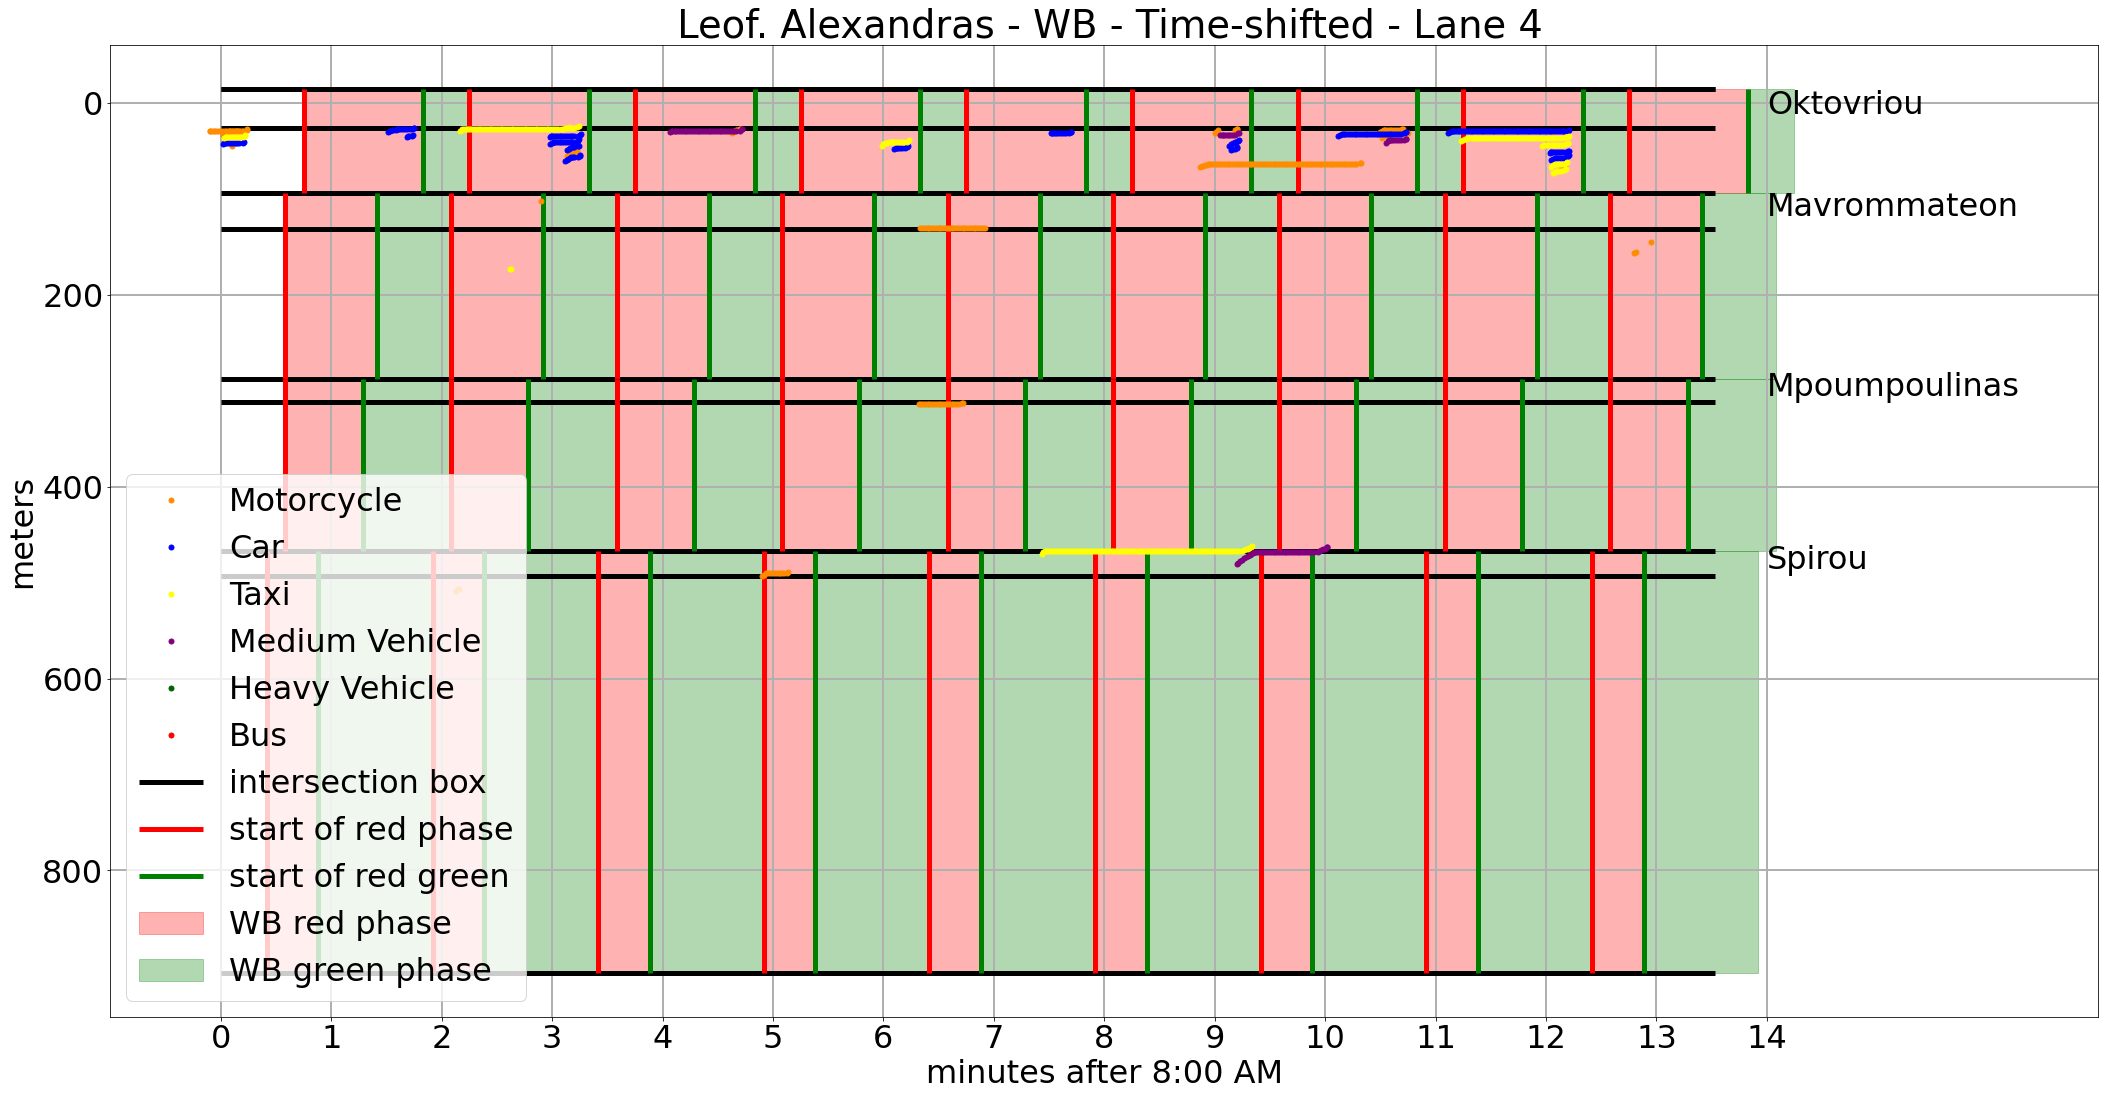

In [199]:
# "intersections" includes (lat,lon) coordinates for each intersection on WB alexandras 
# for each intersection it contains a point on the stop bar at the stop bars on the west side and east side of the intersection 
intersections = [(37.991784,23.731180), (37.991728,23.731559), (37.991627,23.732188), (37.991574,23.732534), 
                 (37.991343,23.733975), (37.991310,23.734203), (37.991081,23.735639), (37.991046,23.735885), (37.990446,23.739709)]
intersections_name = ['Oktovriou', 'Mavrommateon', 'Mpoumpoulinas', 'Spirou']
# load the heading angle of Alexandras from the first row of street_df and save it in "heading" 
heading = street_df.loc[0,'heading']

# find the location of intersections along the road
intersections = intersections_transform(intersections, heading)

# select all vehicles that can be potentially part of a queue
stopped_df = select_stopped_vehicles('Alexandras', 'WB',8)

# determine lanes
stopped_df['lane'] = np.nan
lane_borders = [0, 3.25, 6.5, 9.75, 13]
for i in np.arange(4):
    stopped_df.loc[(stopped_df['Y_road']>lane_borders[i])&(stopped_df['Y_road']<lane_borders[i+1]),'lane'] = i+1
    
# determine (time,location) pairs that corrosponds to the same wave of stopped cars propagating toward the intersection upstreatm
stopped_df = wave_time_delay(stopped_df)

# find max queues and related information
stopped_df = find_max_Q(stopped_df)

# timing plan
timing = [pd.to_datetime('2020-08-04 08:00:45',format='%Y-%m-%d %H:%M:%S.%f'), 
          pd.to_datetime('2020-08-04 08:00:35',format='%Y-%m-%d %H:%M:%S.%f'), 
          pd.to_datetime('2020-08-04 08:00:35',format='%Y-%m-%d %H:%M:%S.%f'),
          pd.to_datetime('2020-08-04 08:00:25',format='%Y-%m-%d %H:%M:%S.%f')]
red_phase = [65, 50, 42, 28]
plot_queues(stopped_df, intersections, intersections_name, 'Leof. Alexandras - WB', timing, red_phase, use_tau= False, reverse_y = True)
plot_queues(stopped_df, intersections, intersections_name, 'Leof. Alexandras - WB - Time-shifted', timing, red_phase, use_tau= True, reverse_y = True)

## EB ALexandars / NB Oktovriou

(i) queue length = 75.57 meters, 12.0 #vehicles
(ii) forms in lane = 2.0
(iii) coordinates: from (37.991583,23.732122) to (37.991427,23.731421)
(iv) max queue occurs at 08:35
(v) spillback occurs, queue starts behind intersection with "Mavrommateon"
    spillback occurs at intersection with "In ramp" at time 08:19


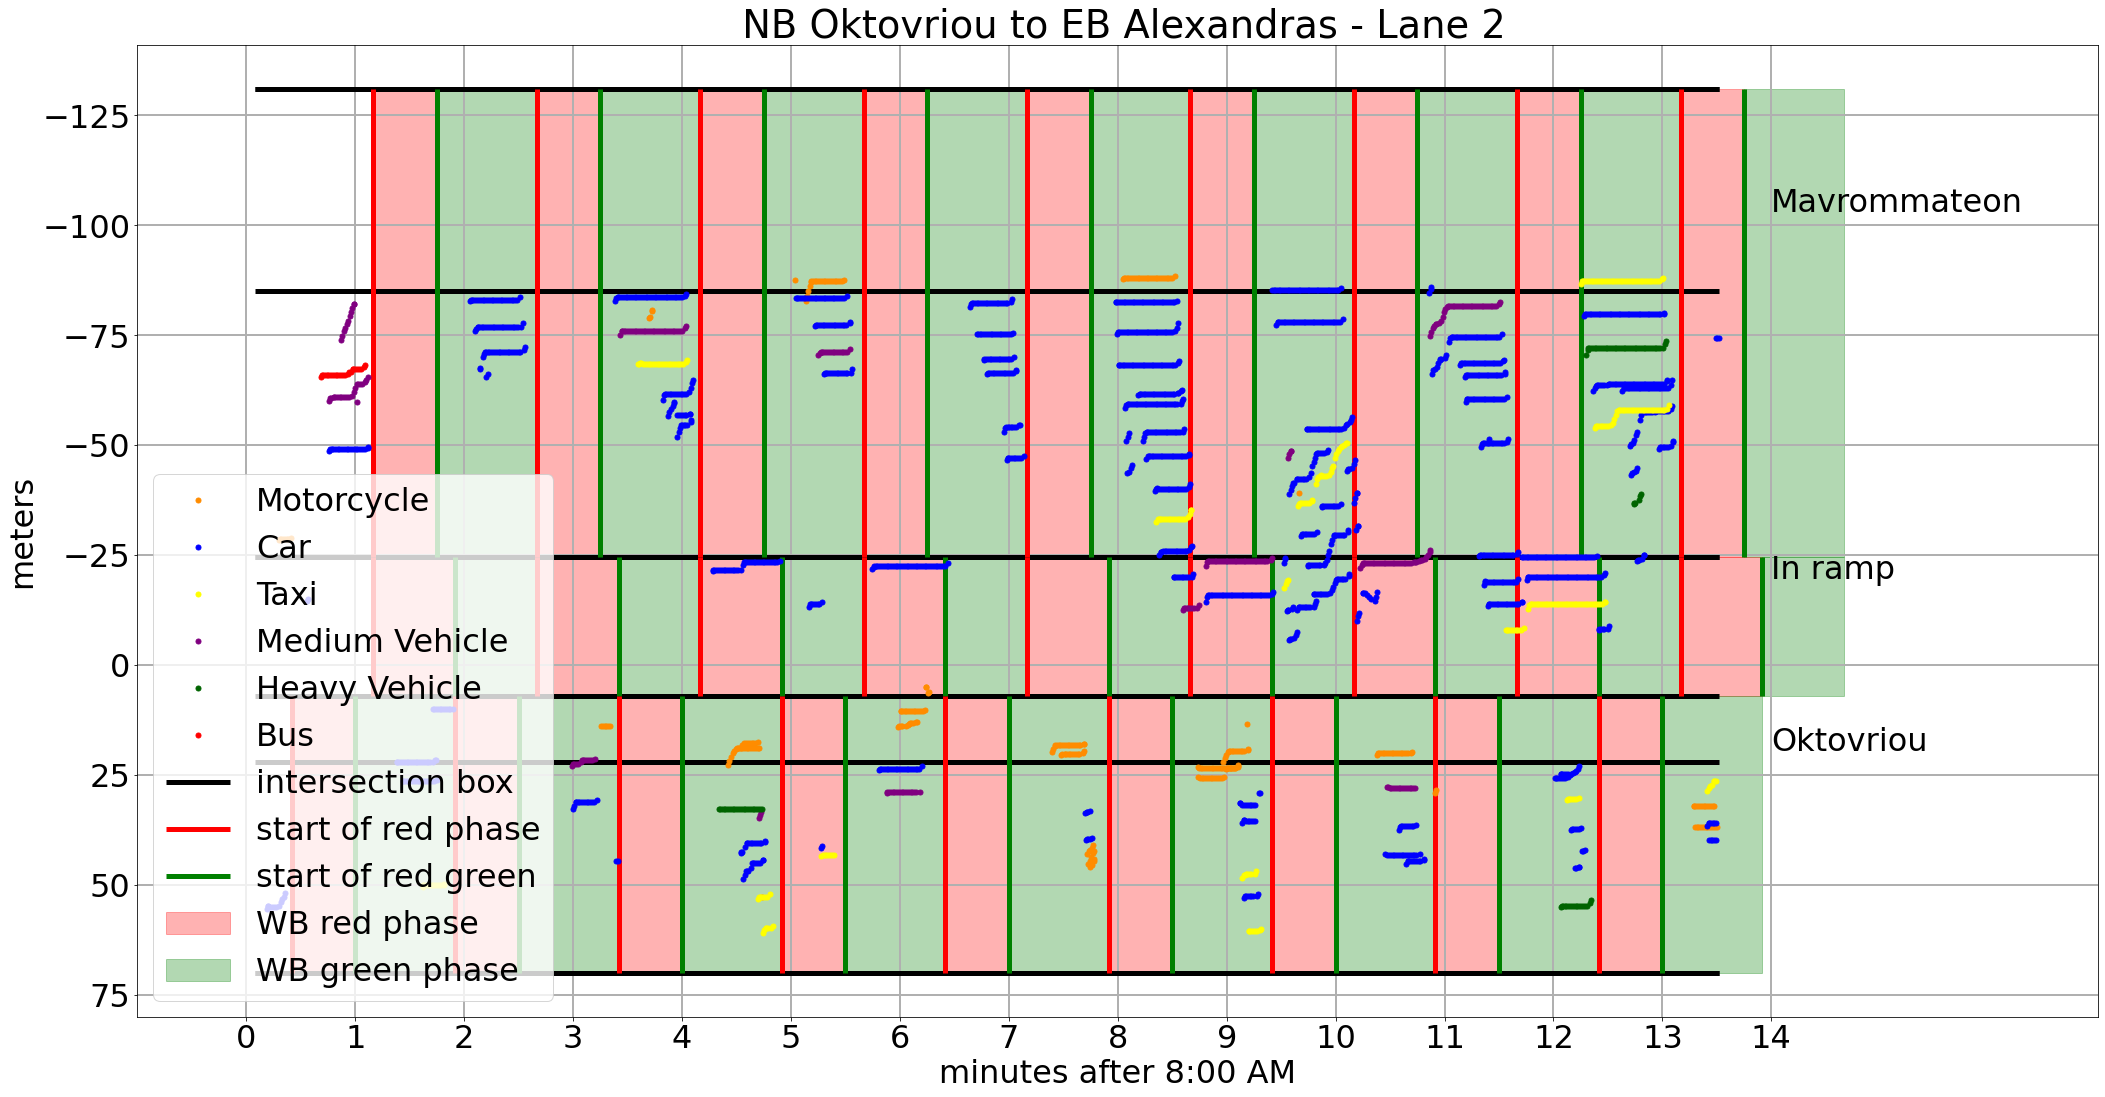

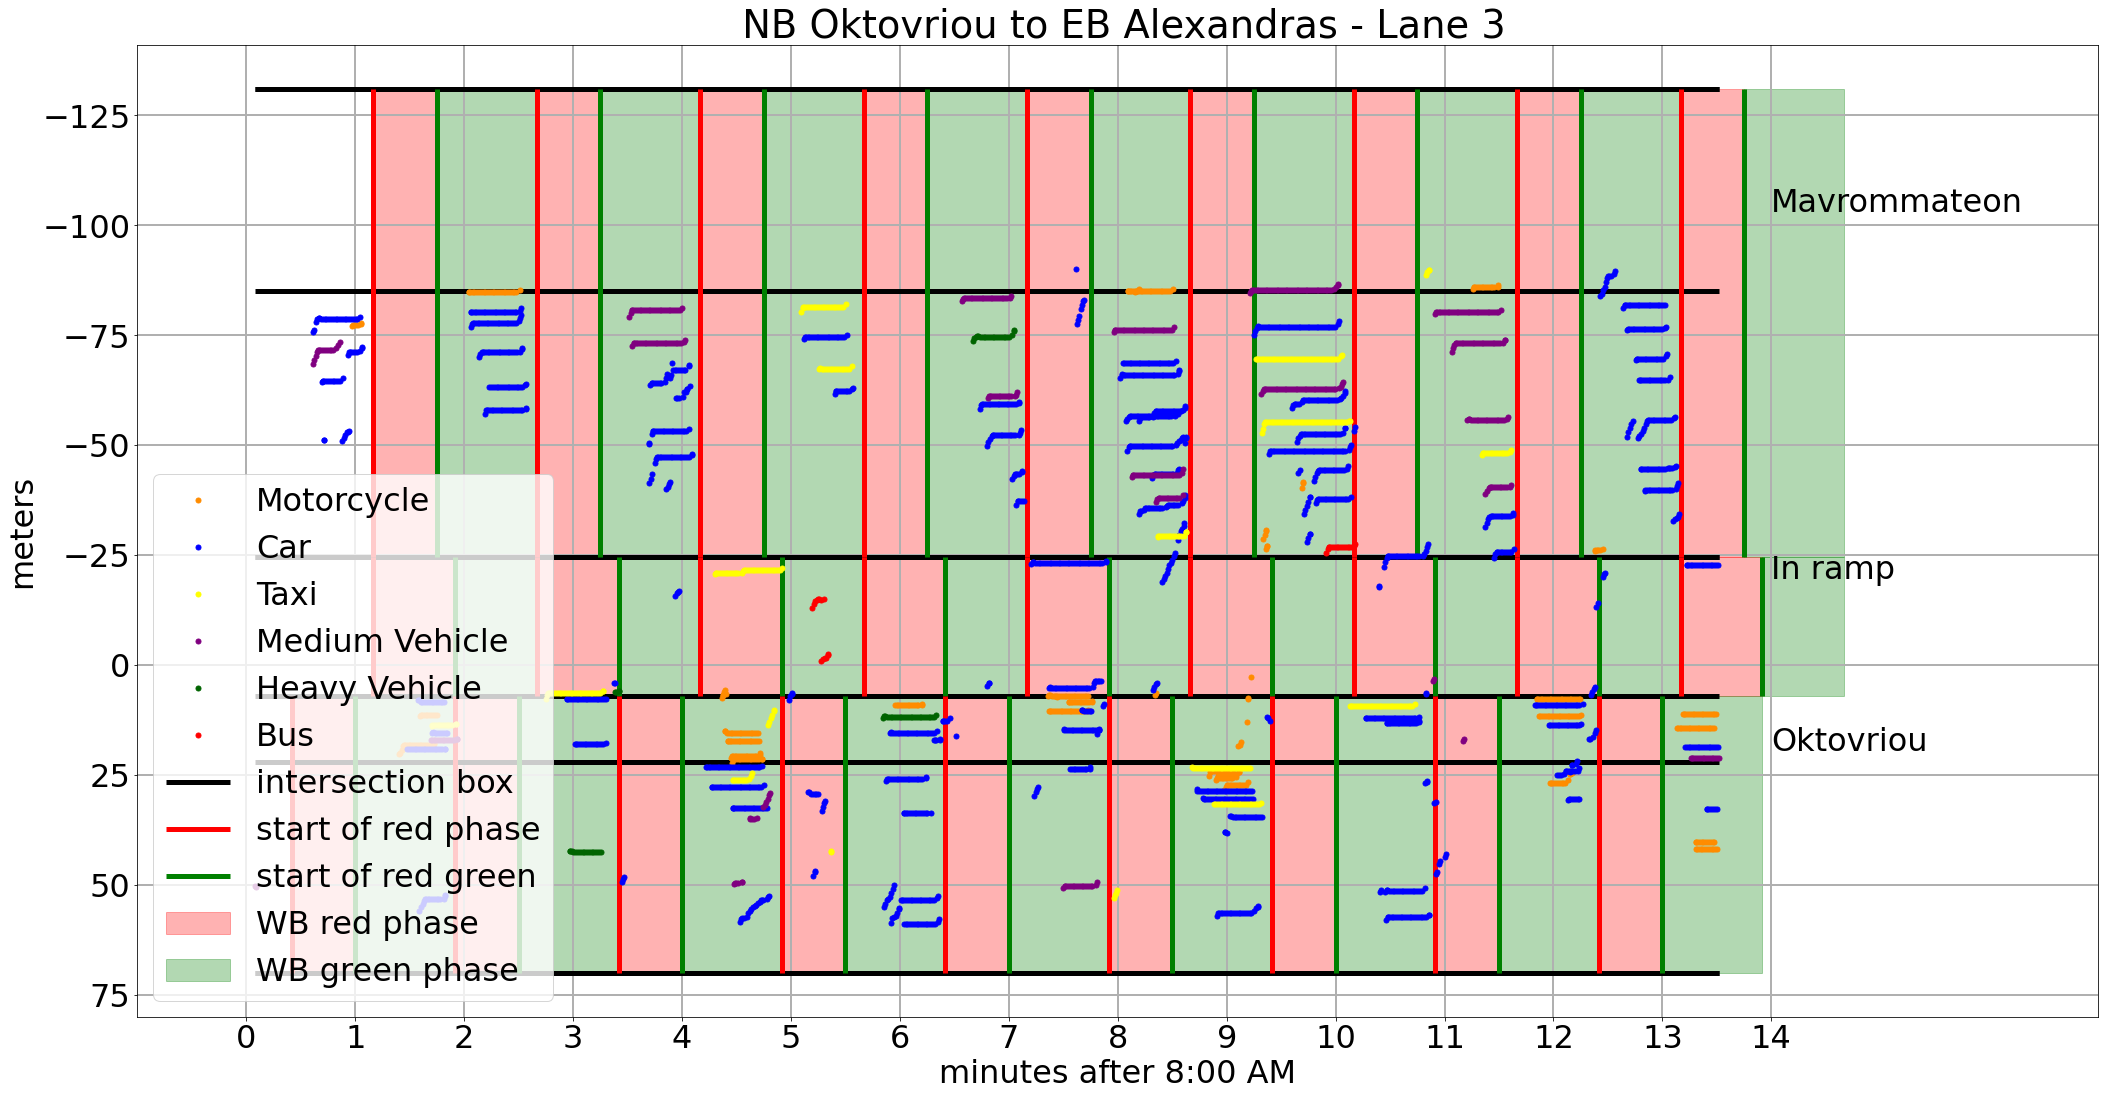

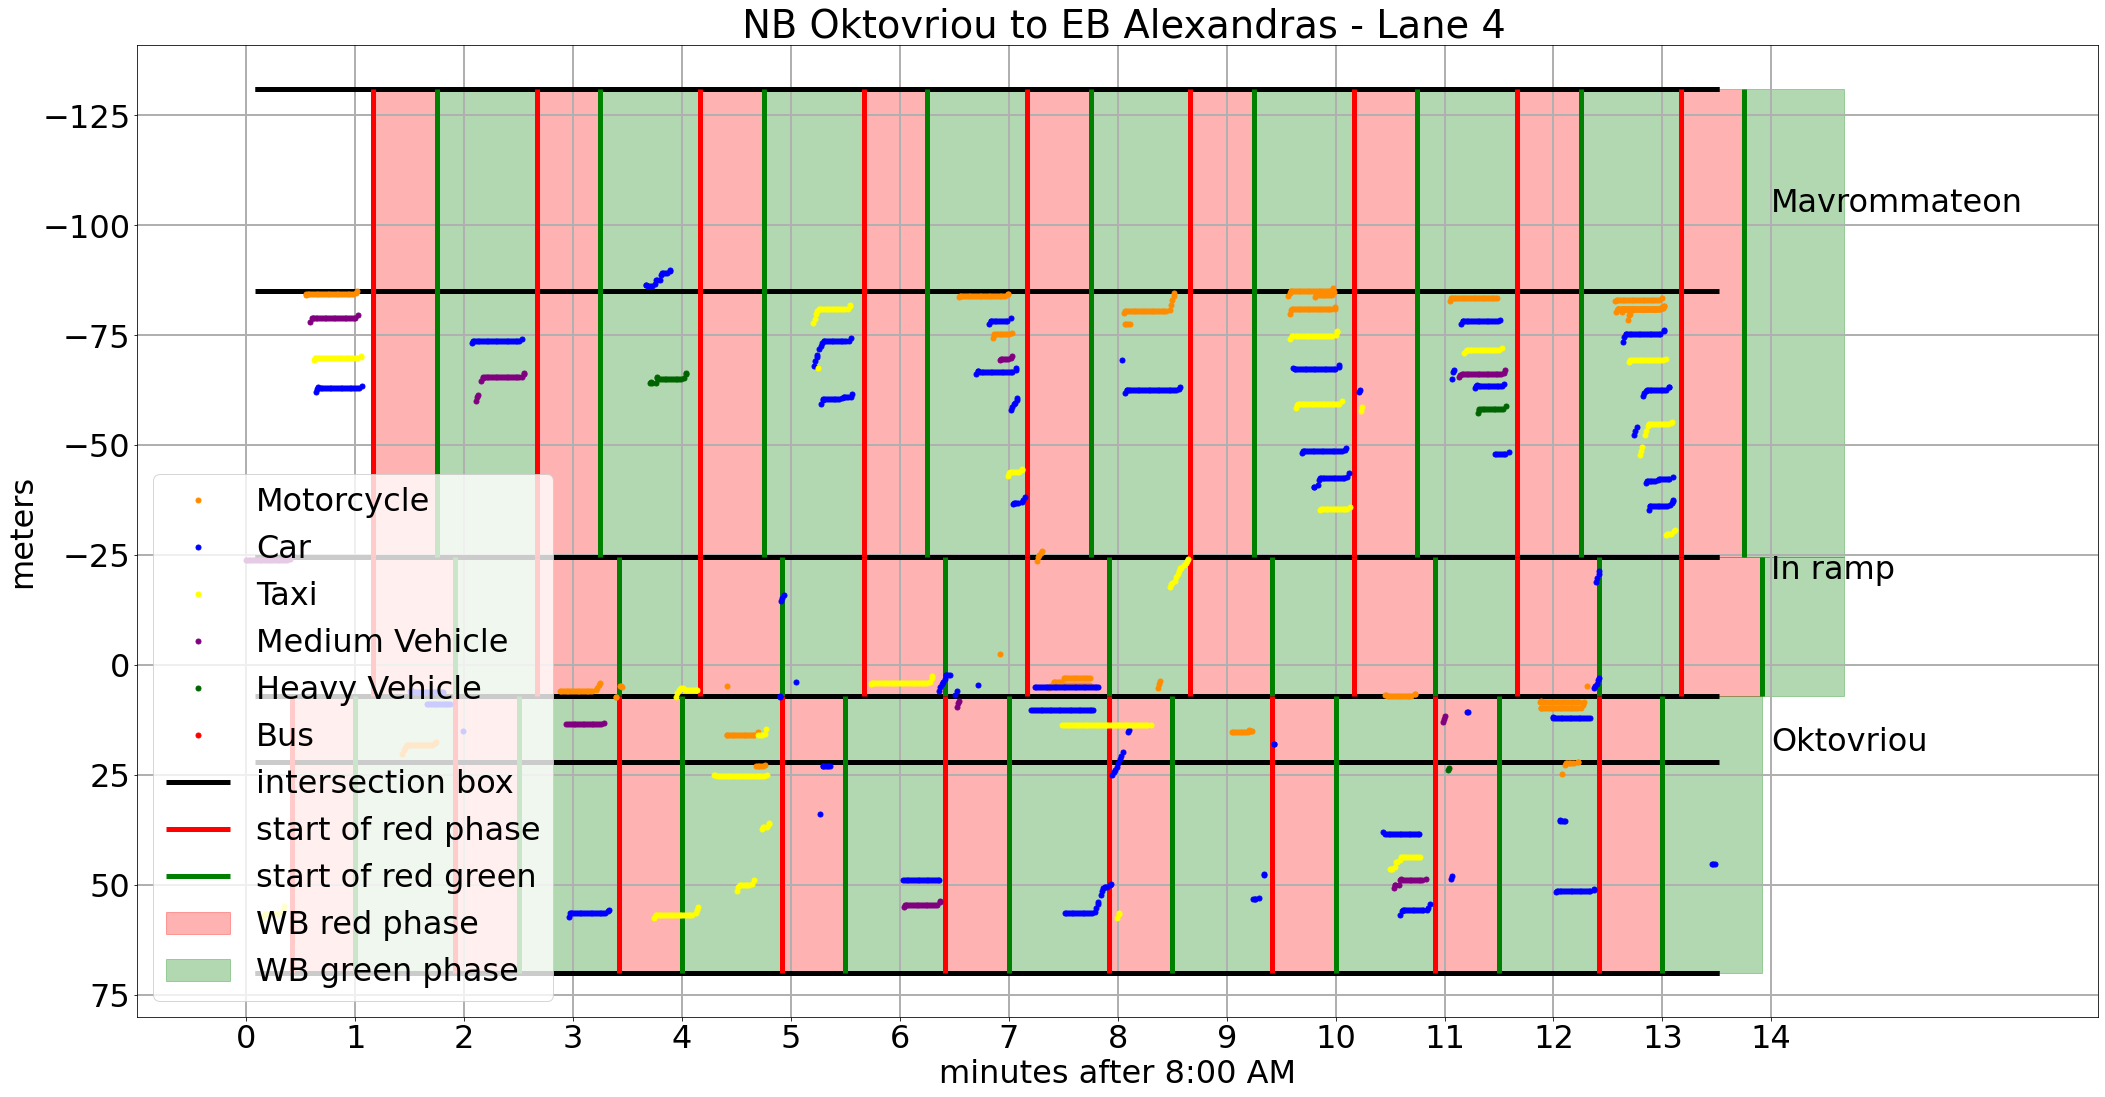

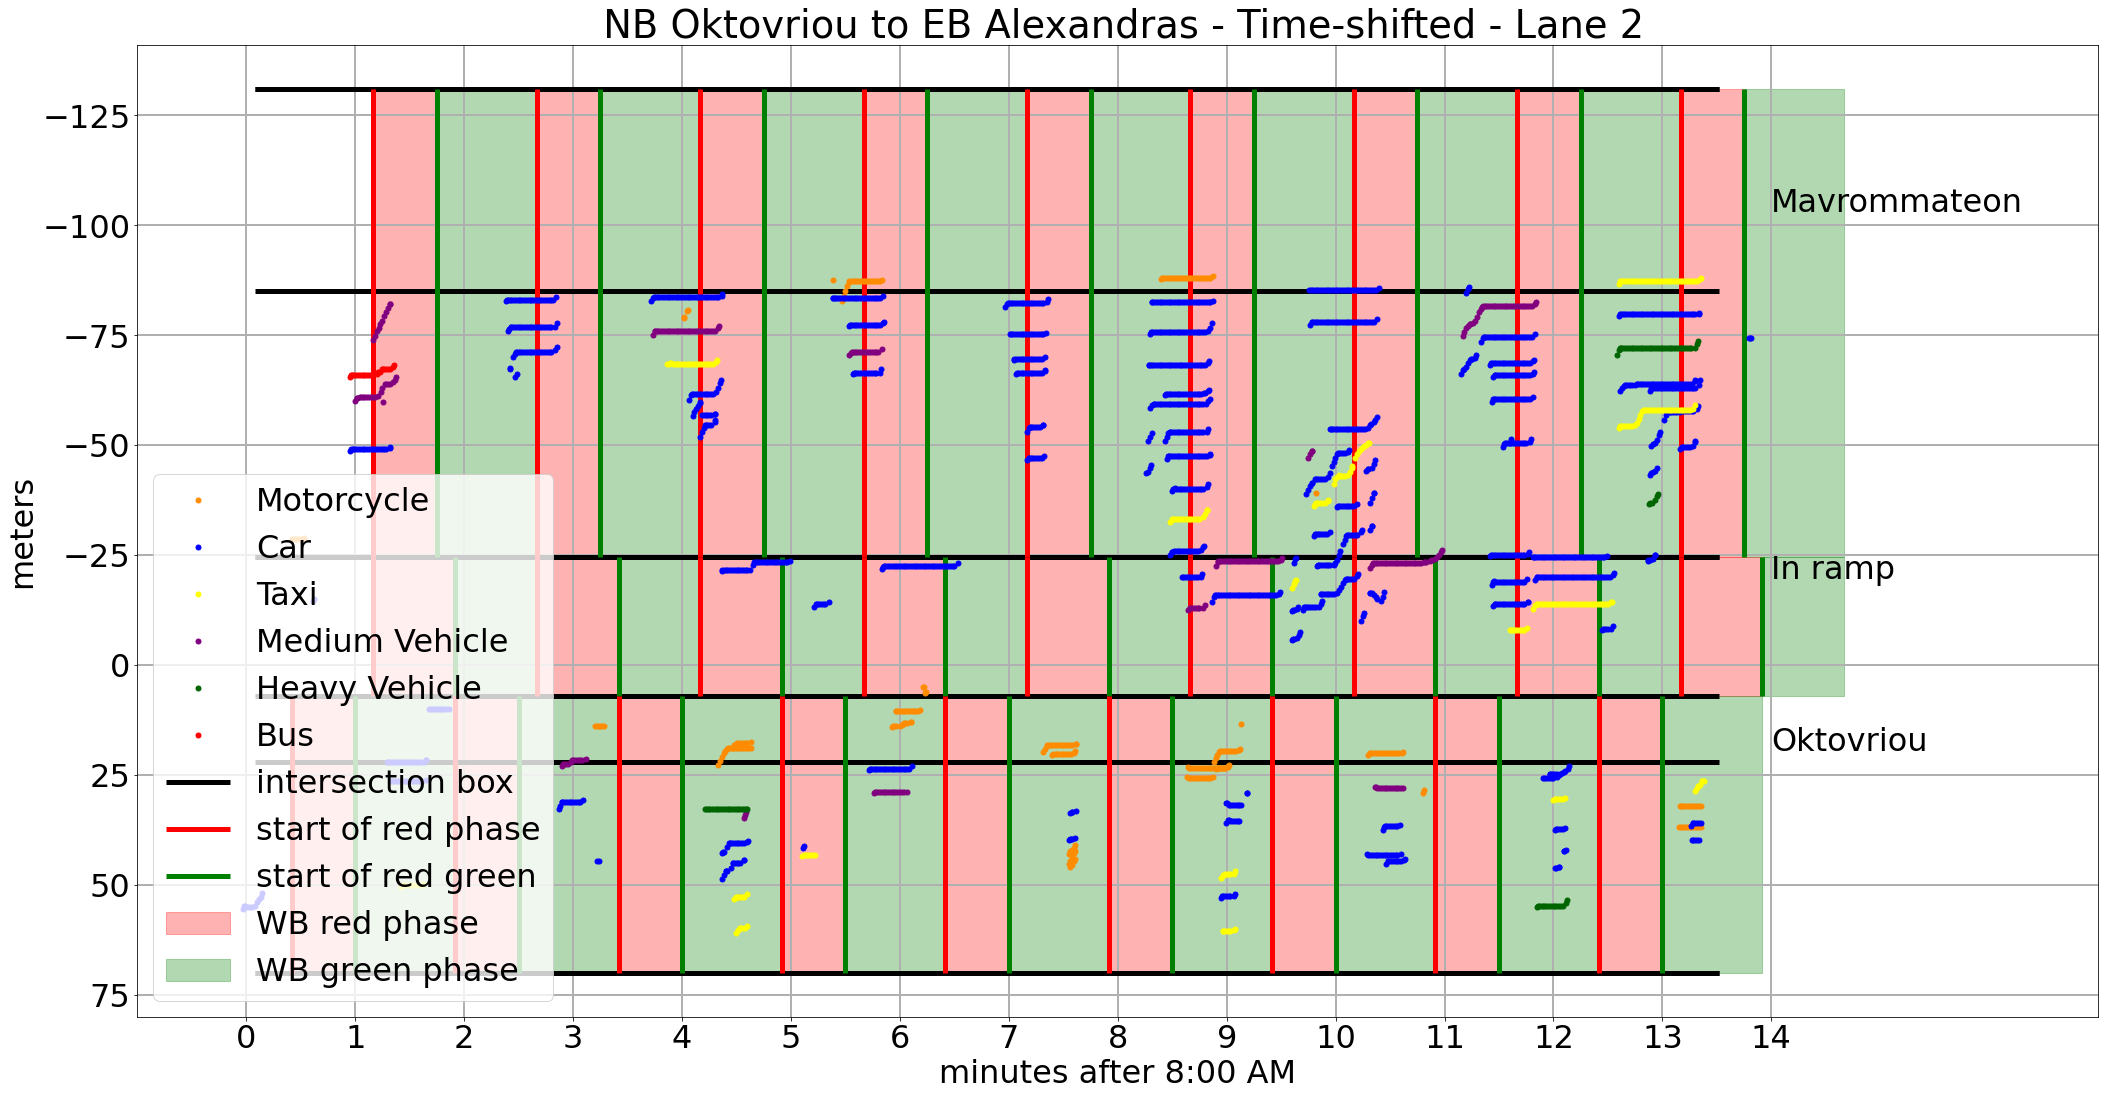

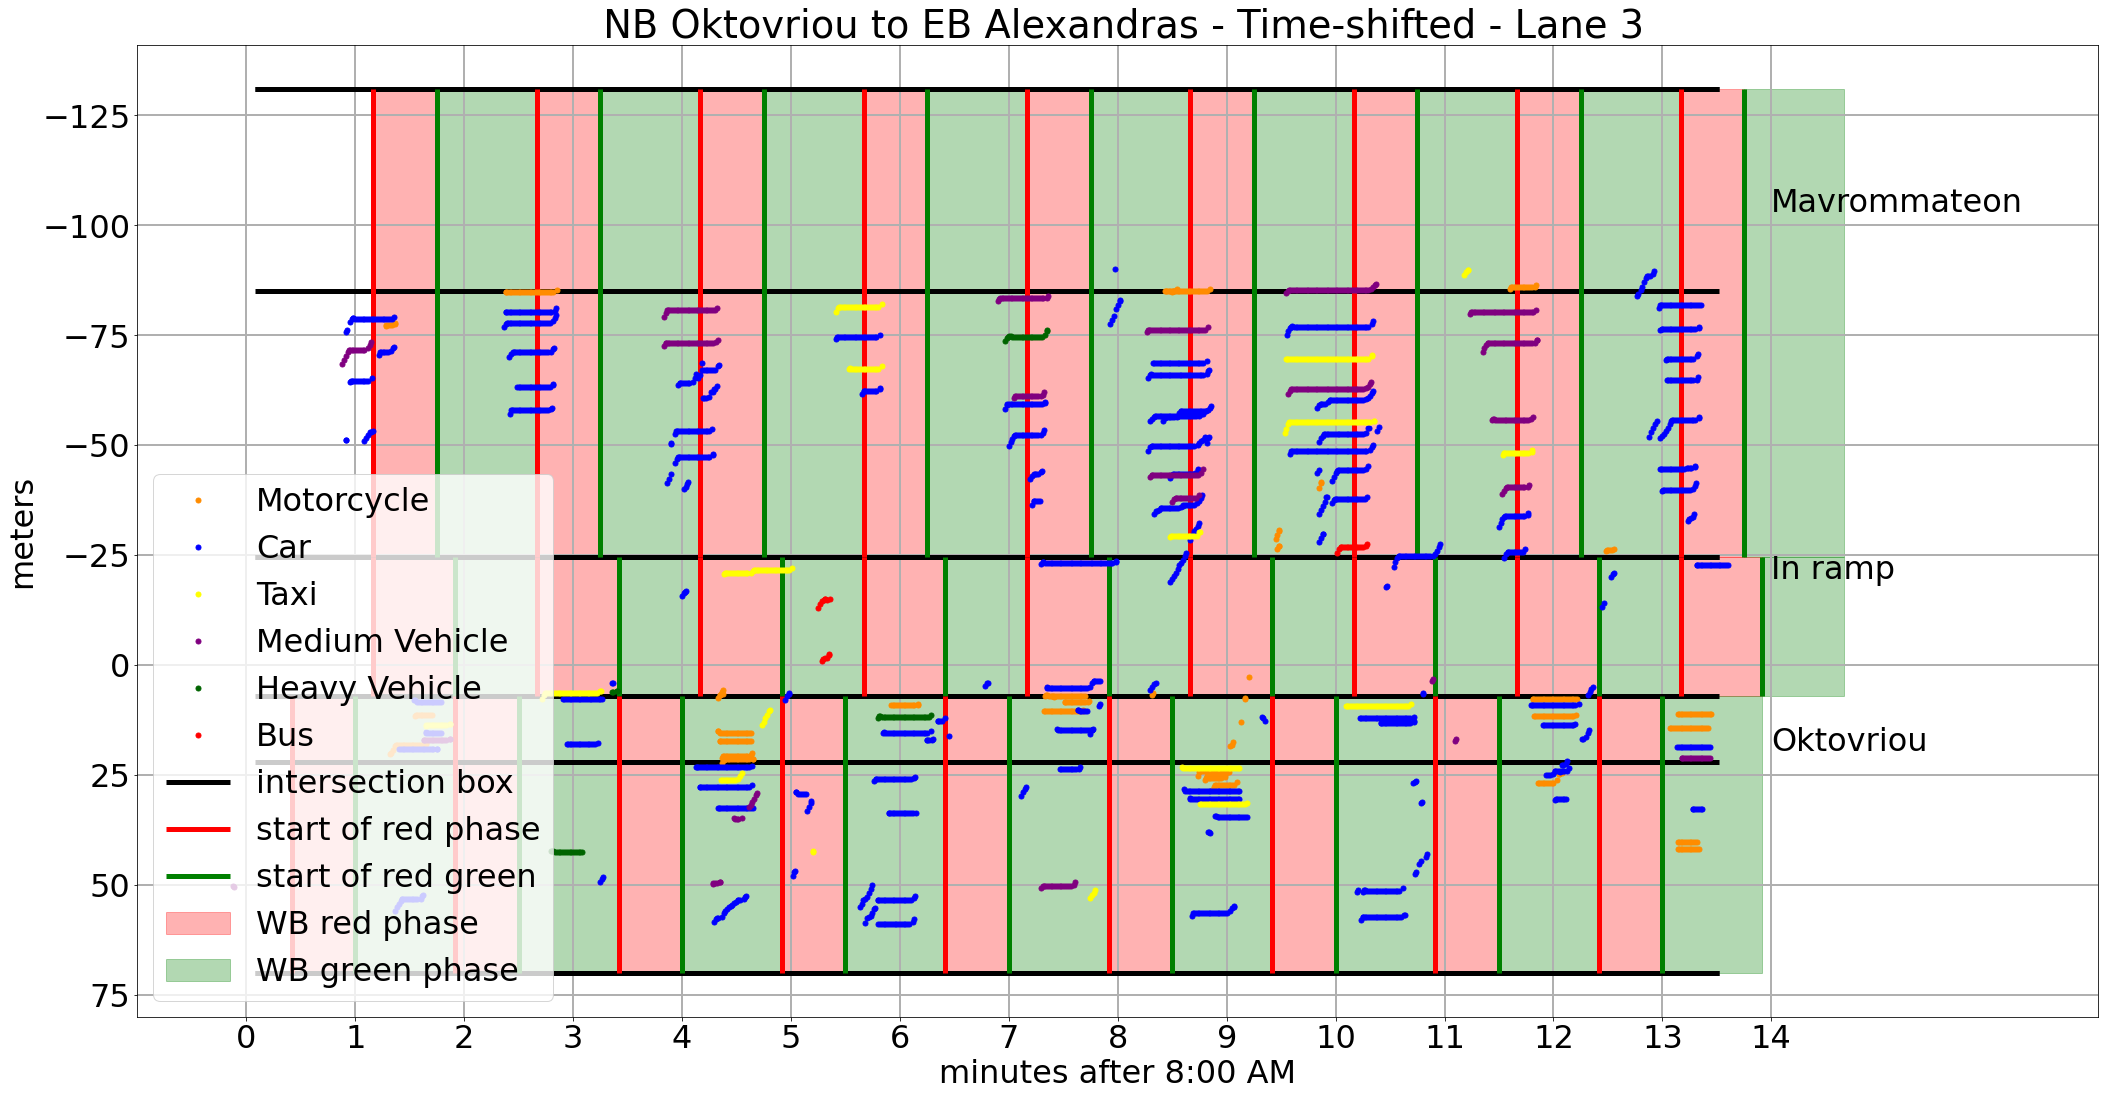

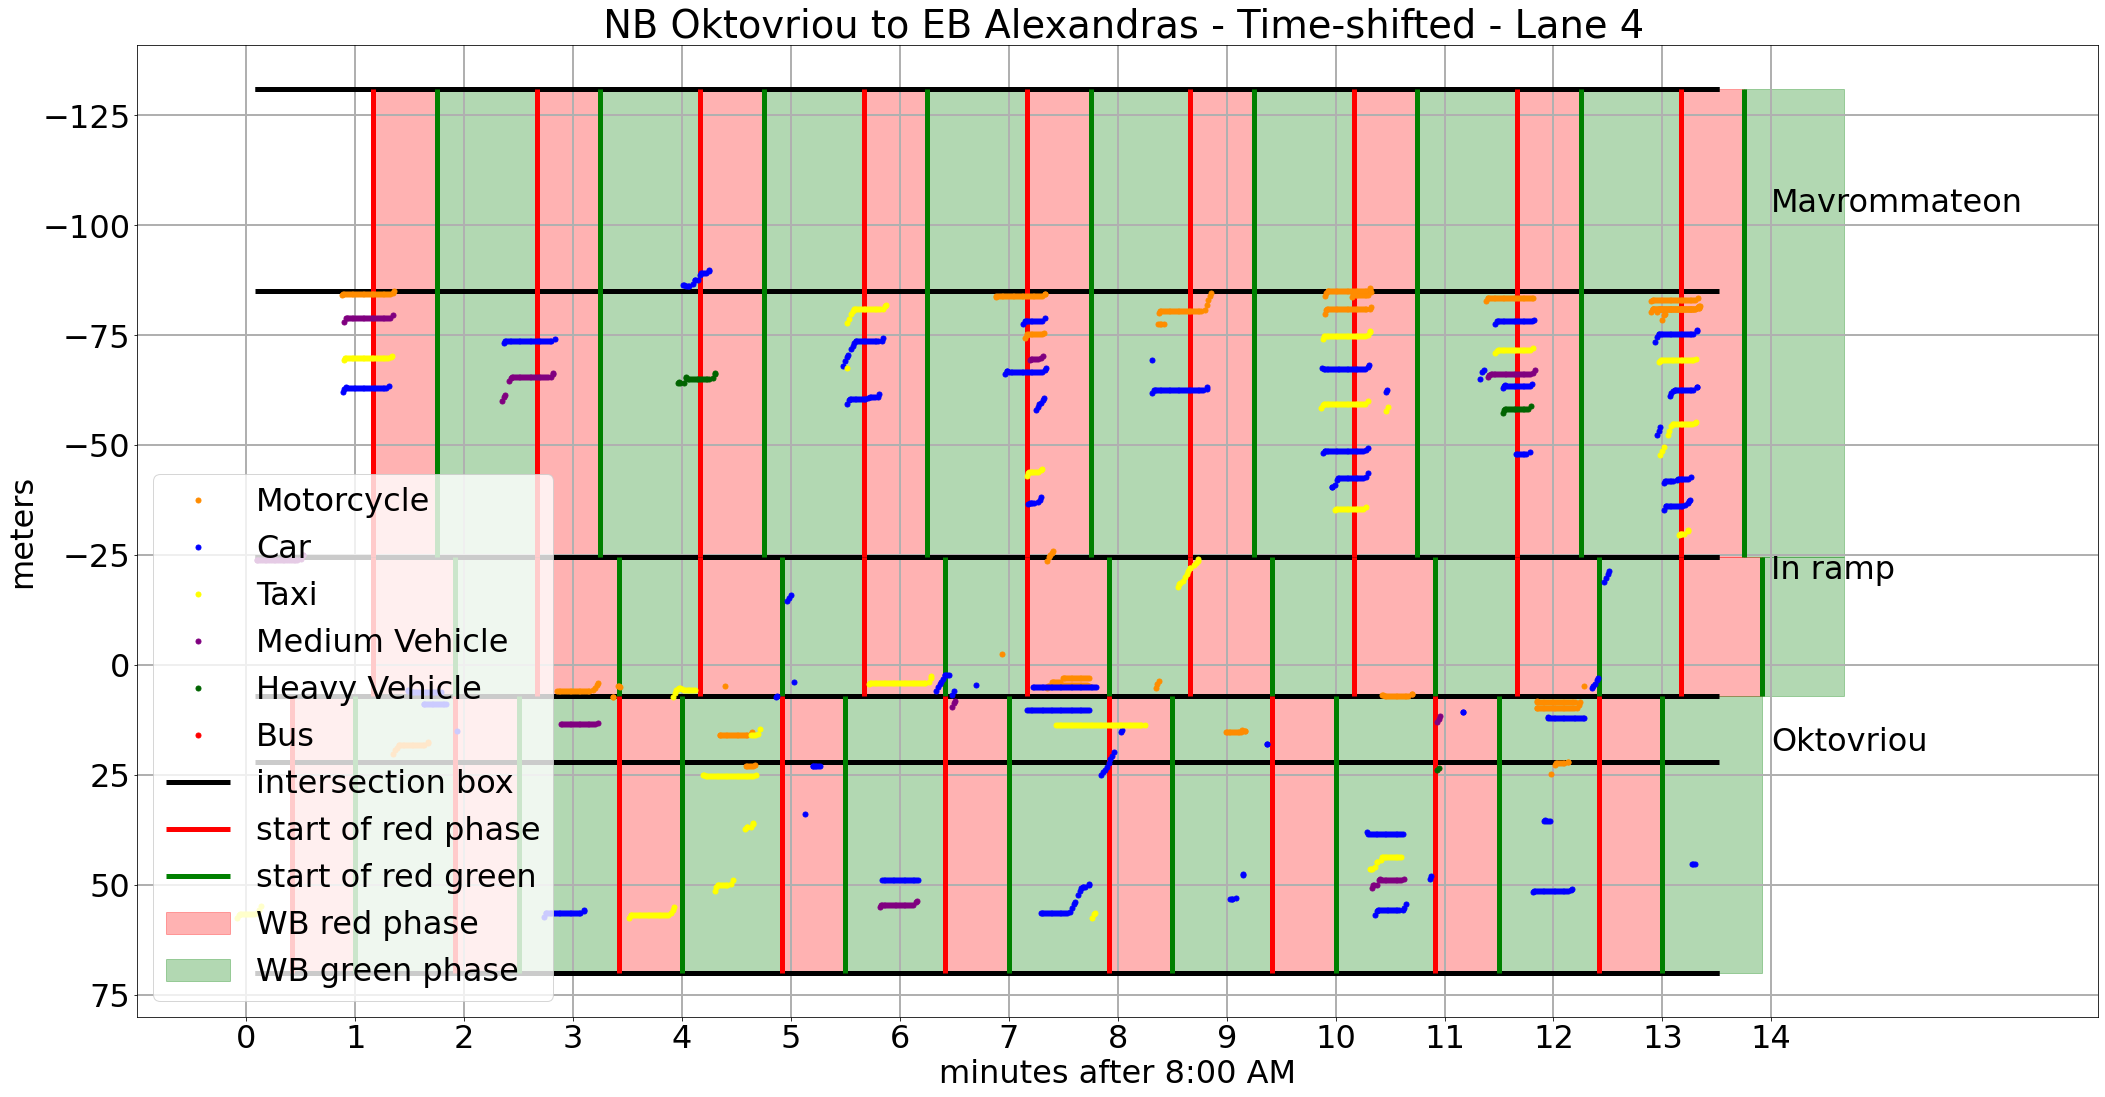

In [194]:
intersections = np.array([-131, -85, -24.57106647,  -24.57106647, 7, 22, 70, 70])
intersections_name = ['Mavrommateon', 'In ramp', 'Oktovriou']

## "intersections" includes (lat,lon) coordinates for each intersection on EB alexandras & NB Octovriou
## for each intersection it contains a point on the stop bar at the stop bars on the west side and east side of the intersection 
#intersections =[(37.991784,23.731180), (37.991717,23.731542), (37.991686,23.731736), (37.991650,23.731969), 
#                (37.991621,23.732157), (37.991542,23.732526), (37.991321,23.733937)]#, (37.991283,23.734181), 
                #(37.991091,23.735388), (37.991013,23.735880), (37.990713,23.737773)]
## load the heading angle of Alexandras from the first row of street_df and save it in "rot" 
#heading = street_df.loc[0,'heading']

## load the heading angle of Alexandras from the first row of street_df and save it in "heading" 
#heading = street_df.loc[0,'heading']

## find the location of intersections along the road
#intersections = intersections_transform(intersections, heading)
##################################################################################################################
# we seperately secelt vehicles on three different segements: NB Alexandras, in ramp, and NB Oktovriou

# select all vehicles that can be potentially part of a queue on EB Alexandras
stopped_alexandras_df = select_stopped_vehicles('Alexandras', 'EB', 5)

# determine lanes
stopped_alexandras_df['lane'] = np.nan
lane_borders = [-0.75, -4, -7.25, -10.5, -13.75]
for i in np.arange(4):
    stopped_alexandras_df.loc[(stopped_alexandras_df['Y_road']<-3.25*i-0.75)&(stopped_alexandras_df['Y_road']>-3.25*(i+1)-0.75),'lane'] = i+1
    
    
# select all vehicles that can be potentially part of a queue on in ramp
stopped_ramp_df = select_stopped_vehicles('In_ramp',None, 5)

# determine lanes
stopped_ramp_df['lane'] = np.nan
# determine lanes
stopped_ramp_df['lane'] = np.nan
lane_borders = [-10, 4,7.5,11.5,15]
for i in np.arange(4):
    stopped_ramp_df.loc[(stopped_ramp_df['Y_road']>lane_borders[i])&(stopped_ramp_df['Y_road']<lane_borders[i+1]),'lane'] = 4-i
    
    
# select all vehicles that can be potentially part of a queue on in ramp
stopped_oktovriou_df = select_stopped_vehicles('Oktovriou','NB',5)

# determine lanes
stopped_oktovriou_df['lane'] = np.nan
lane_borders = [0,5,8.25,11.5,14.75]
for i in np.arange(4):
    stopped_oktovriou_df.loc[(-stopped_oktovriou_df['Y_road']>lane_borders[i])&(-stopped_oktovriou_df['Y_road']<lane_borders[i+1]),'lane'] = i+1
####################################################################################################################
# merge data from three segemtns
# offset the values of X_raod for data on in ramp and Oktovriou, to align the end of one segment to the begining of the next segment
stopped_ramp_df['X_road'] = stopped_ramp_df['X_road'] - 2
stopped_oktovriou_df['X_road'] = stopped_oktovriou_df['X_road'] + 70
# filter out the vehicles on Oktovriou that do not turn into in ramp (move further north beyond X_road = 15)
stopped_oktovriou_df = stopped_oktovriou_df[stopped_oktovriou_df['X_road']<15]
stopped_oktovriou_df = stopped_oktovriou_df[stopped_oktovriou_df['X_road']>-70]

stopped_df = pd.concat([stopped_alexandras_df, stopped_ramp_df, stopped_oktovriou_df])
#stopped_df = stopped_oktovriou_df
# select the vehicles behind Mavrommateon intersection
stopped_df = stopped_df[stopped_df['X_road']<90]
# drop the cars on left turn lane (lane 1)
stopped_df = stopped_df[stopped_df['lane']>1]
####################################################################################################################
# determine (time,location) pairs that corrosponds to the same wave of stopped cars propagating toward the intersection upstreatm
stopped_df = wave_time_delay(stopped_df,-15)

# find max queues and related information
stopped_df['X_road'] = - stopped_df['X_road']
stopped_df = find_max_Q(stopped_df)

# timing plan
timing = [pd.to_datetime('2020-08-04 08:01:10',format='%Y-%m-%d %H:%M:%S.%f'),
          pd.to_datetime('2020-08-04 08:01:10',format='%Y-%m-%d %H:%M:%S.%f'),
          pd.to_datetime('2020-08-04 08:00:25',format='%Y-%m-%d %H:%M:%S.%f')]
red_phase = [35, 45, 35]
plot_queues(stopped_df, intersections, intersections_name, 'NB Oktovriou to EB Alexandras', timing, red_phase, use_tau = False, reverse_y = True, lane_set = [2,3,4])
plot_queues(stopped_df, intersections, intersections_name, 'NB Oktovriou to EB Alexandras - Time-shifted', timing, red_phase, use_tau= True, reverse_y = True, lane_set = [2,3,4])

## SB Oktovriou

(i) queue length = 102.15 meters, 14.0 #vehicles
(ii) forms in lane = 2.0
(iii) coordinates: from (37.991893,23.731268) to (37.992773,23.731496)
(iv) max queue occurs at 05:55
(v) no spillback, queue starts behind intersection of "Alexandras"


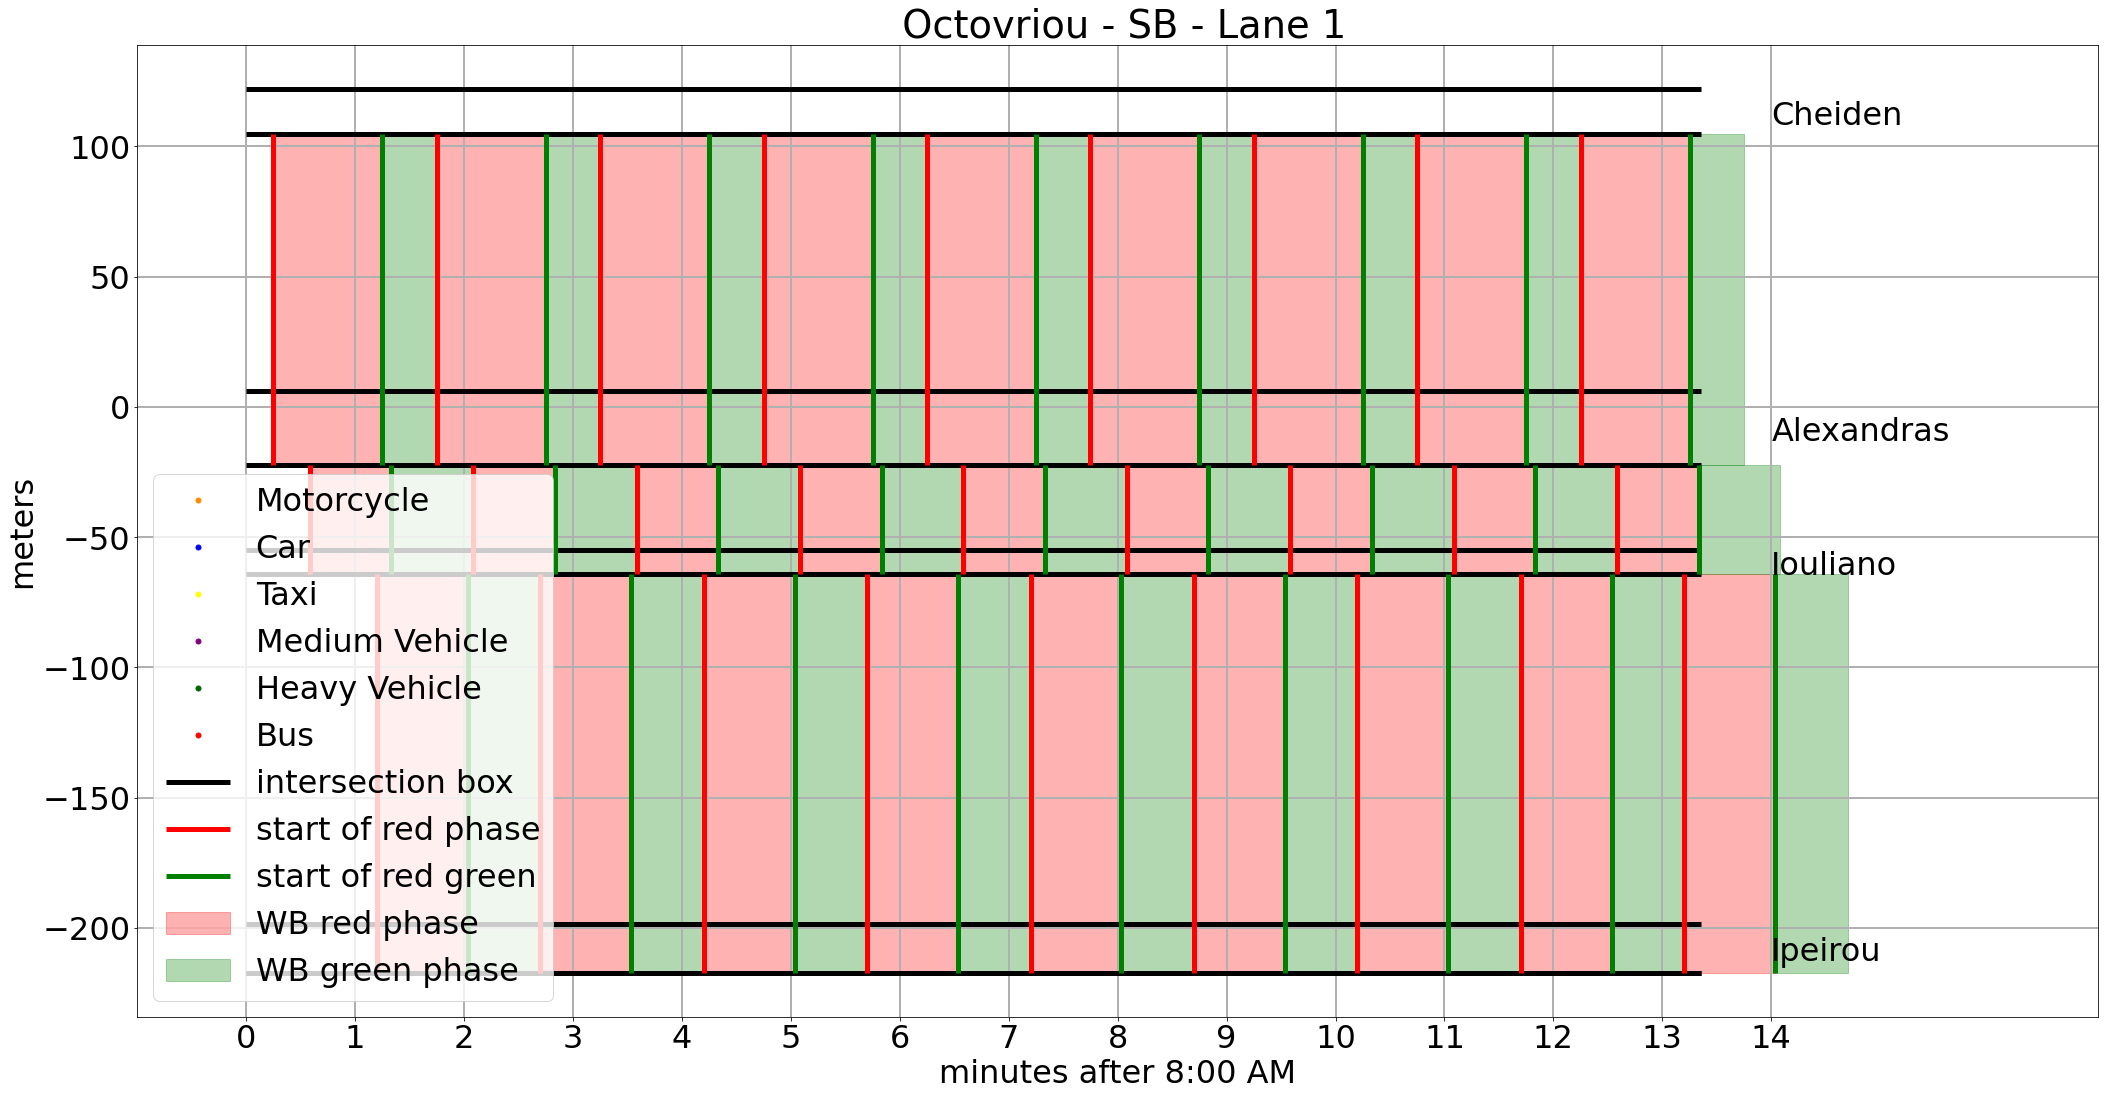

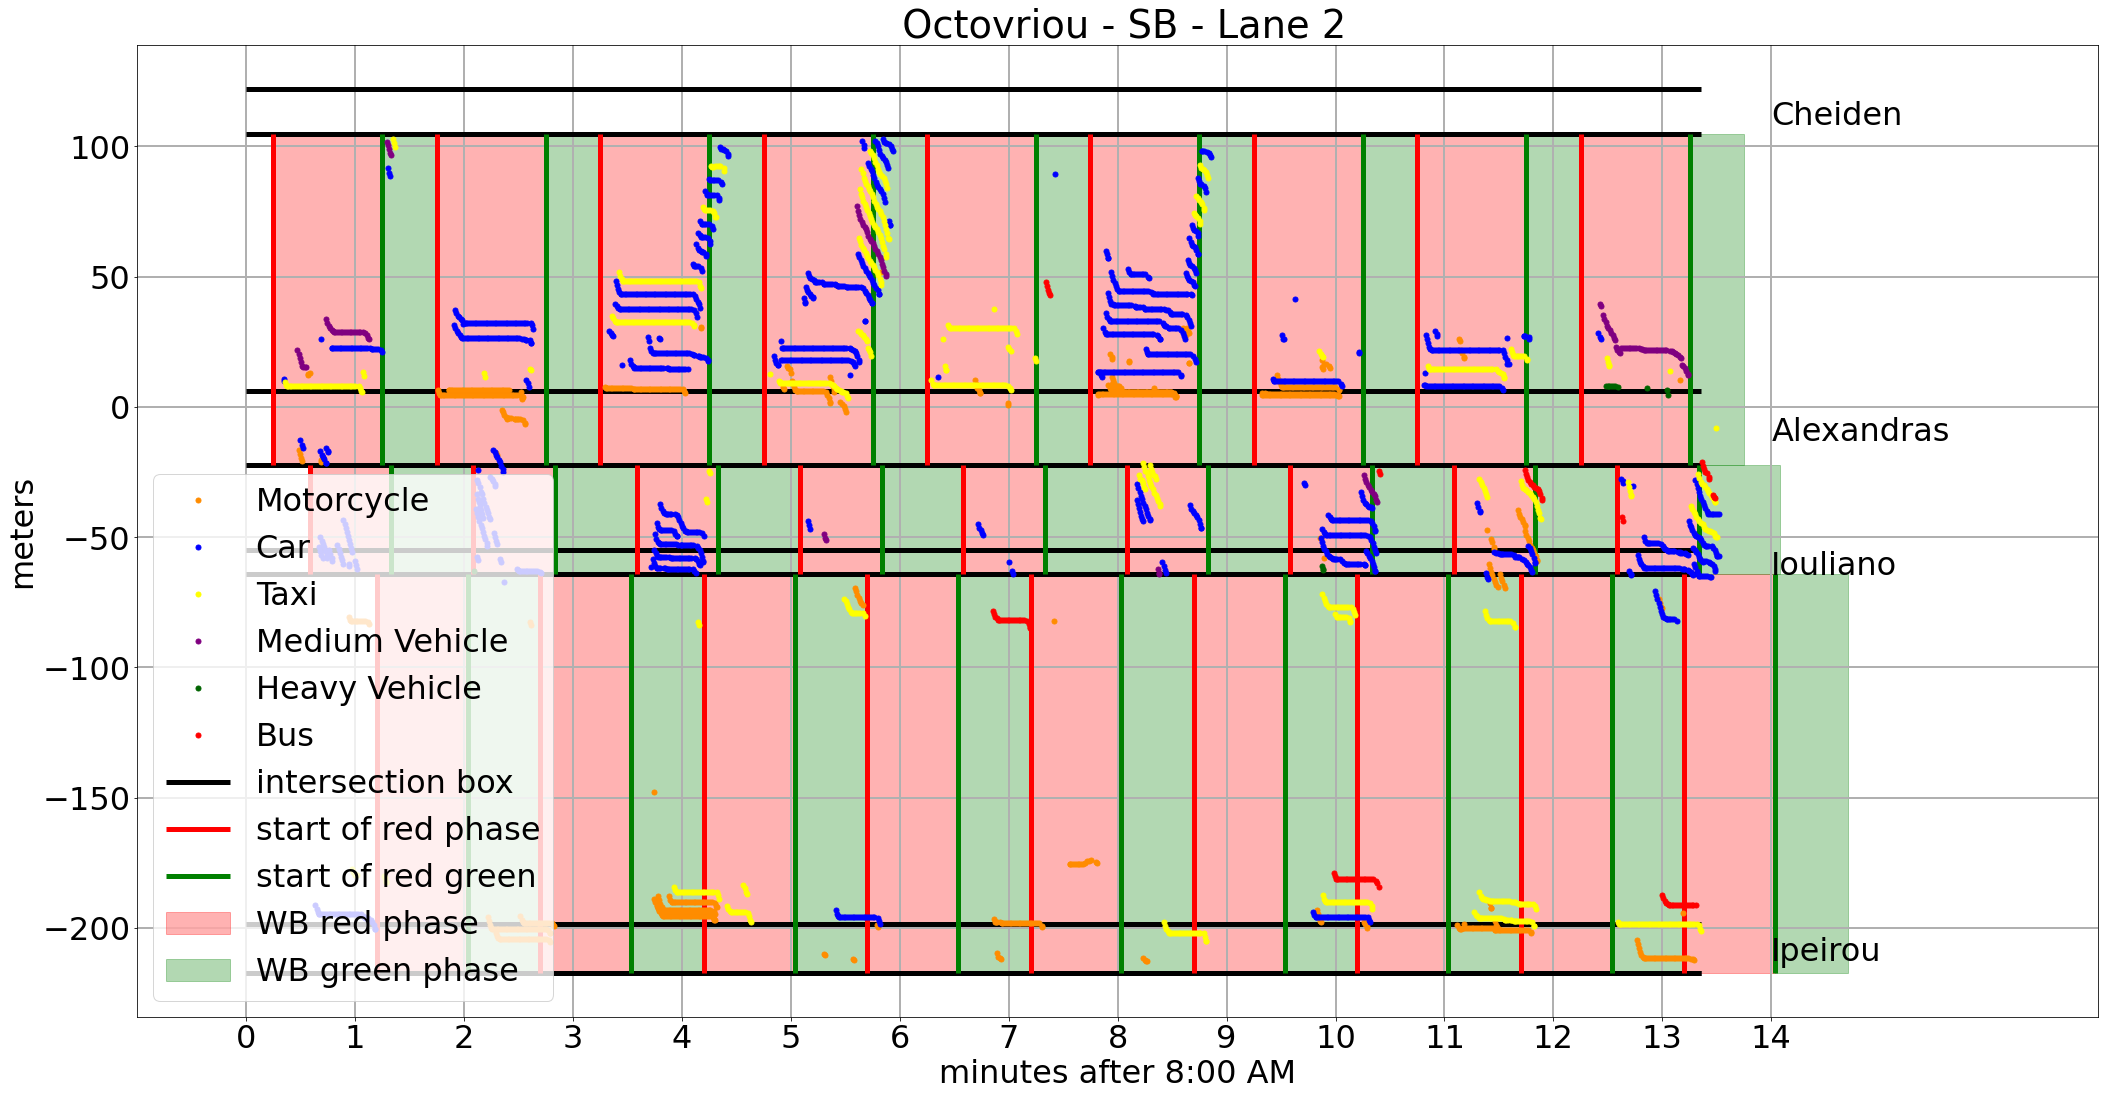

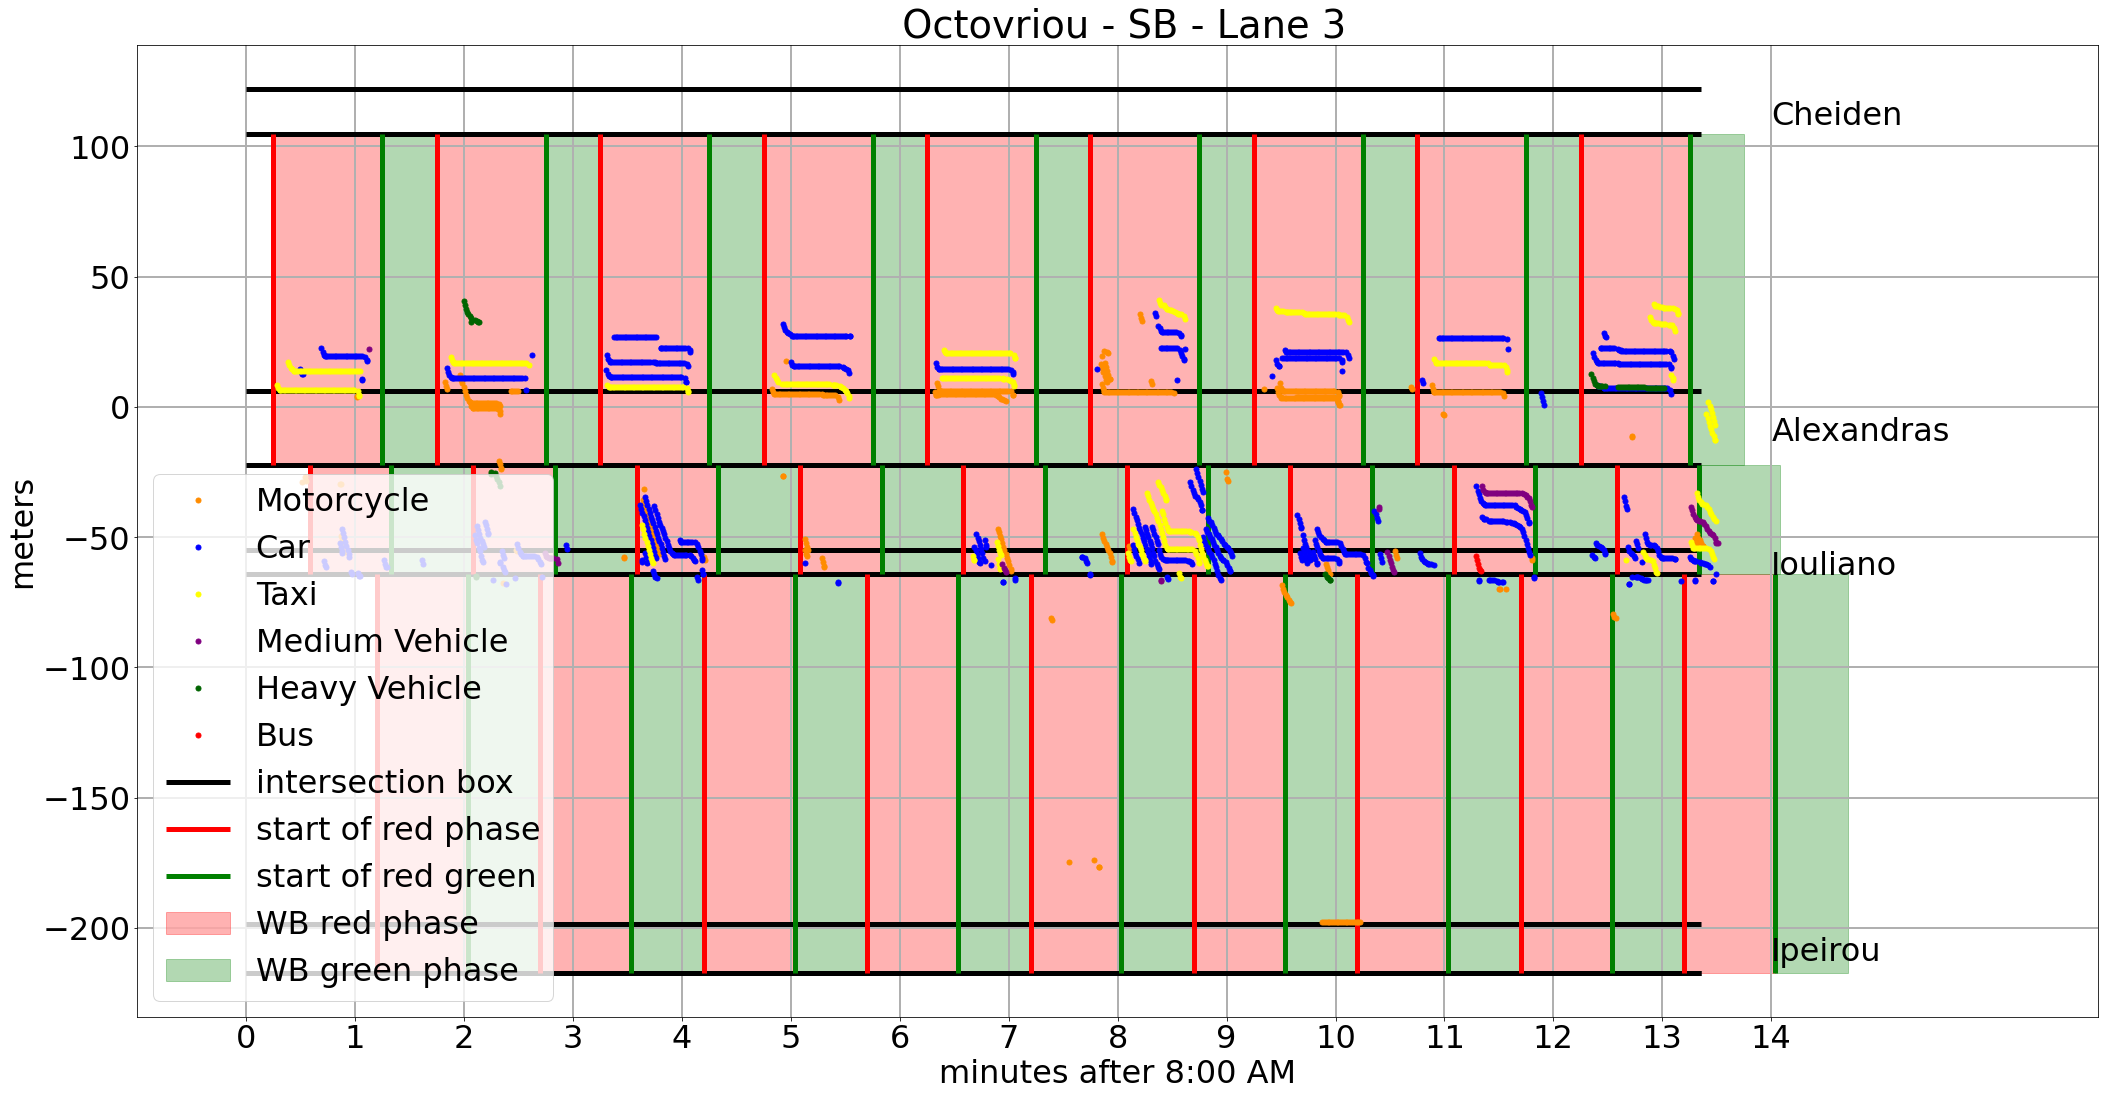

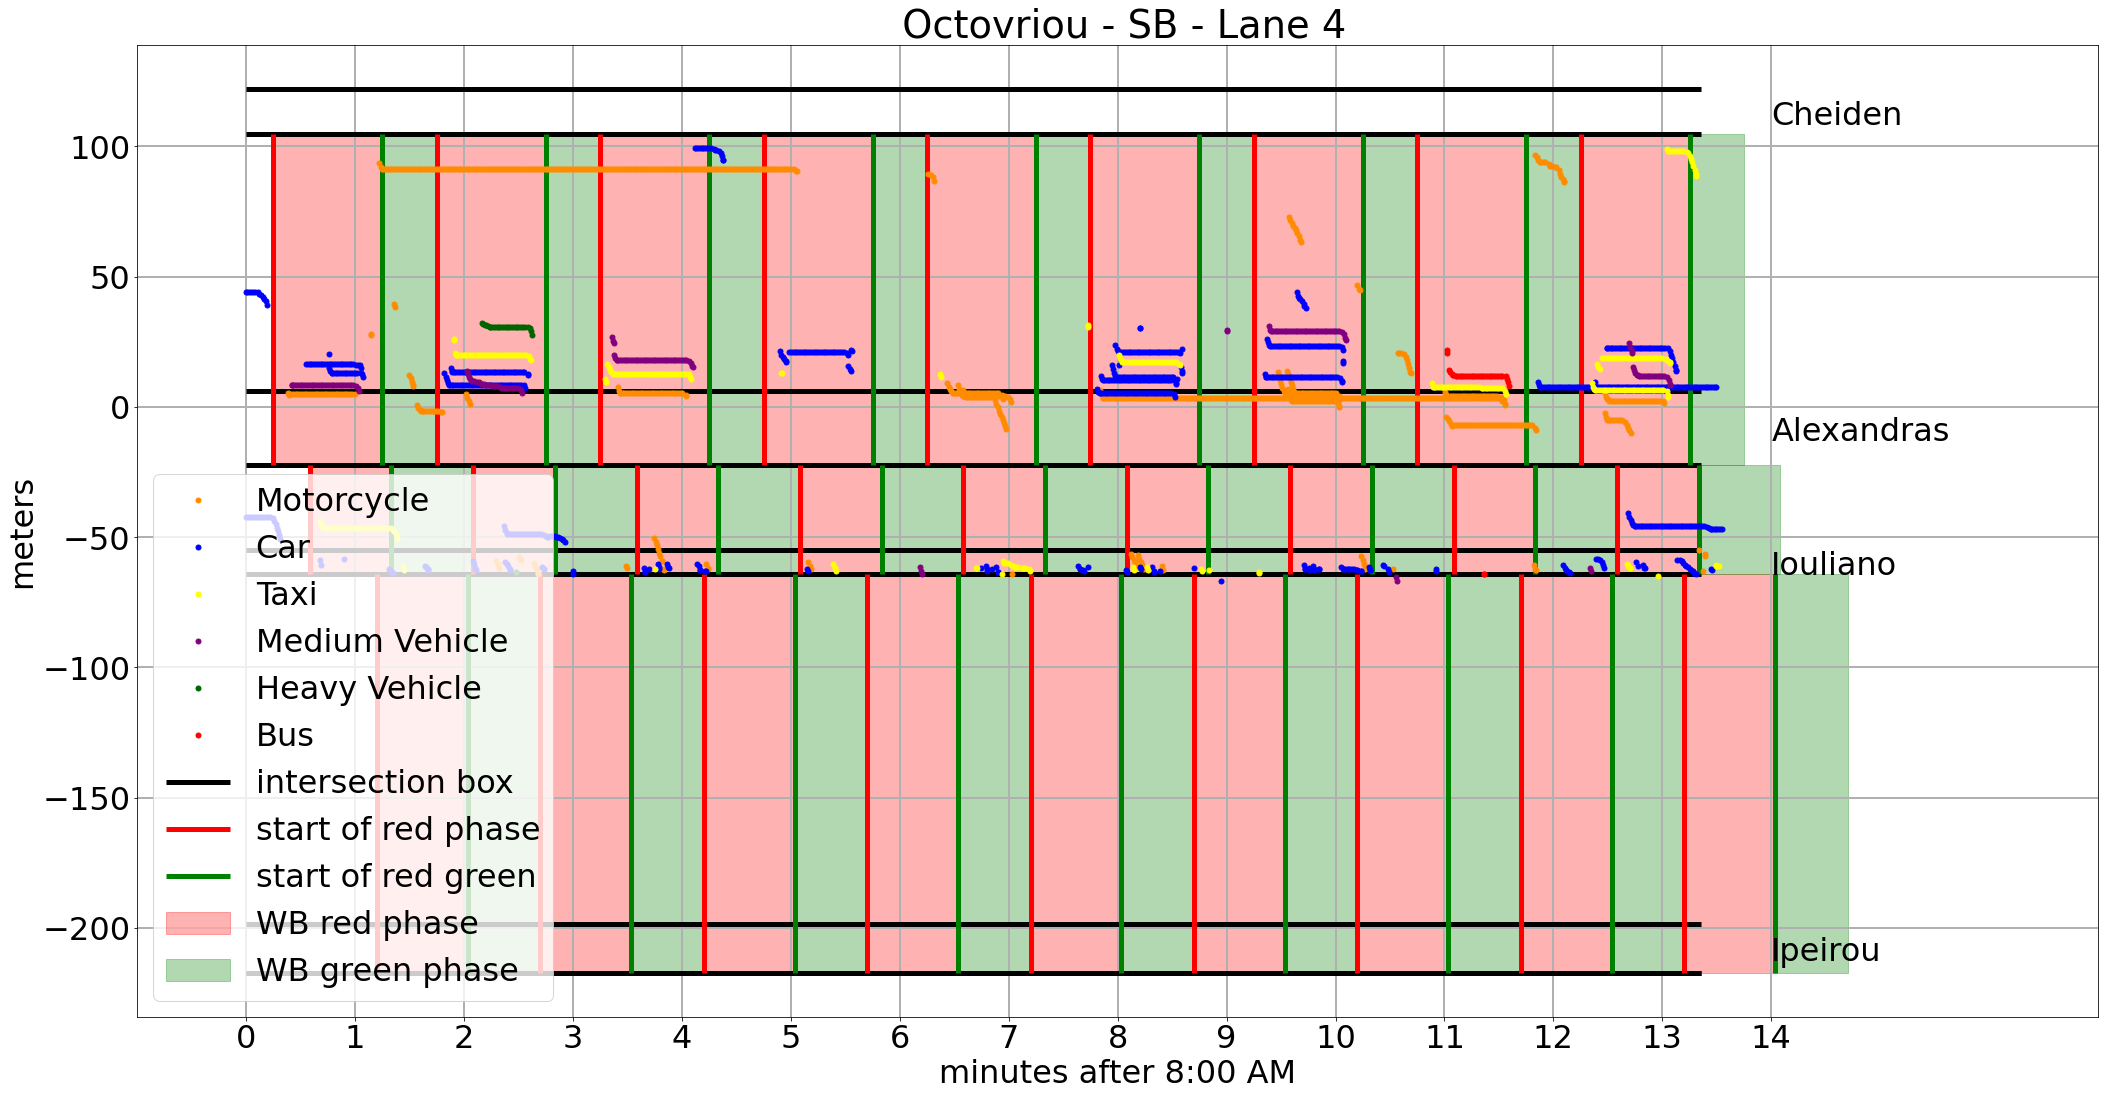

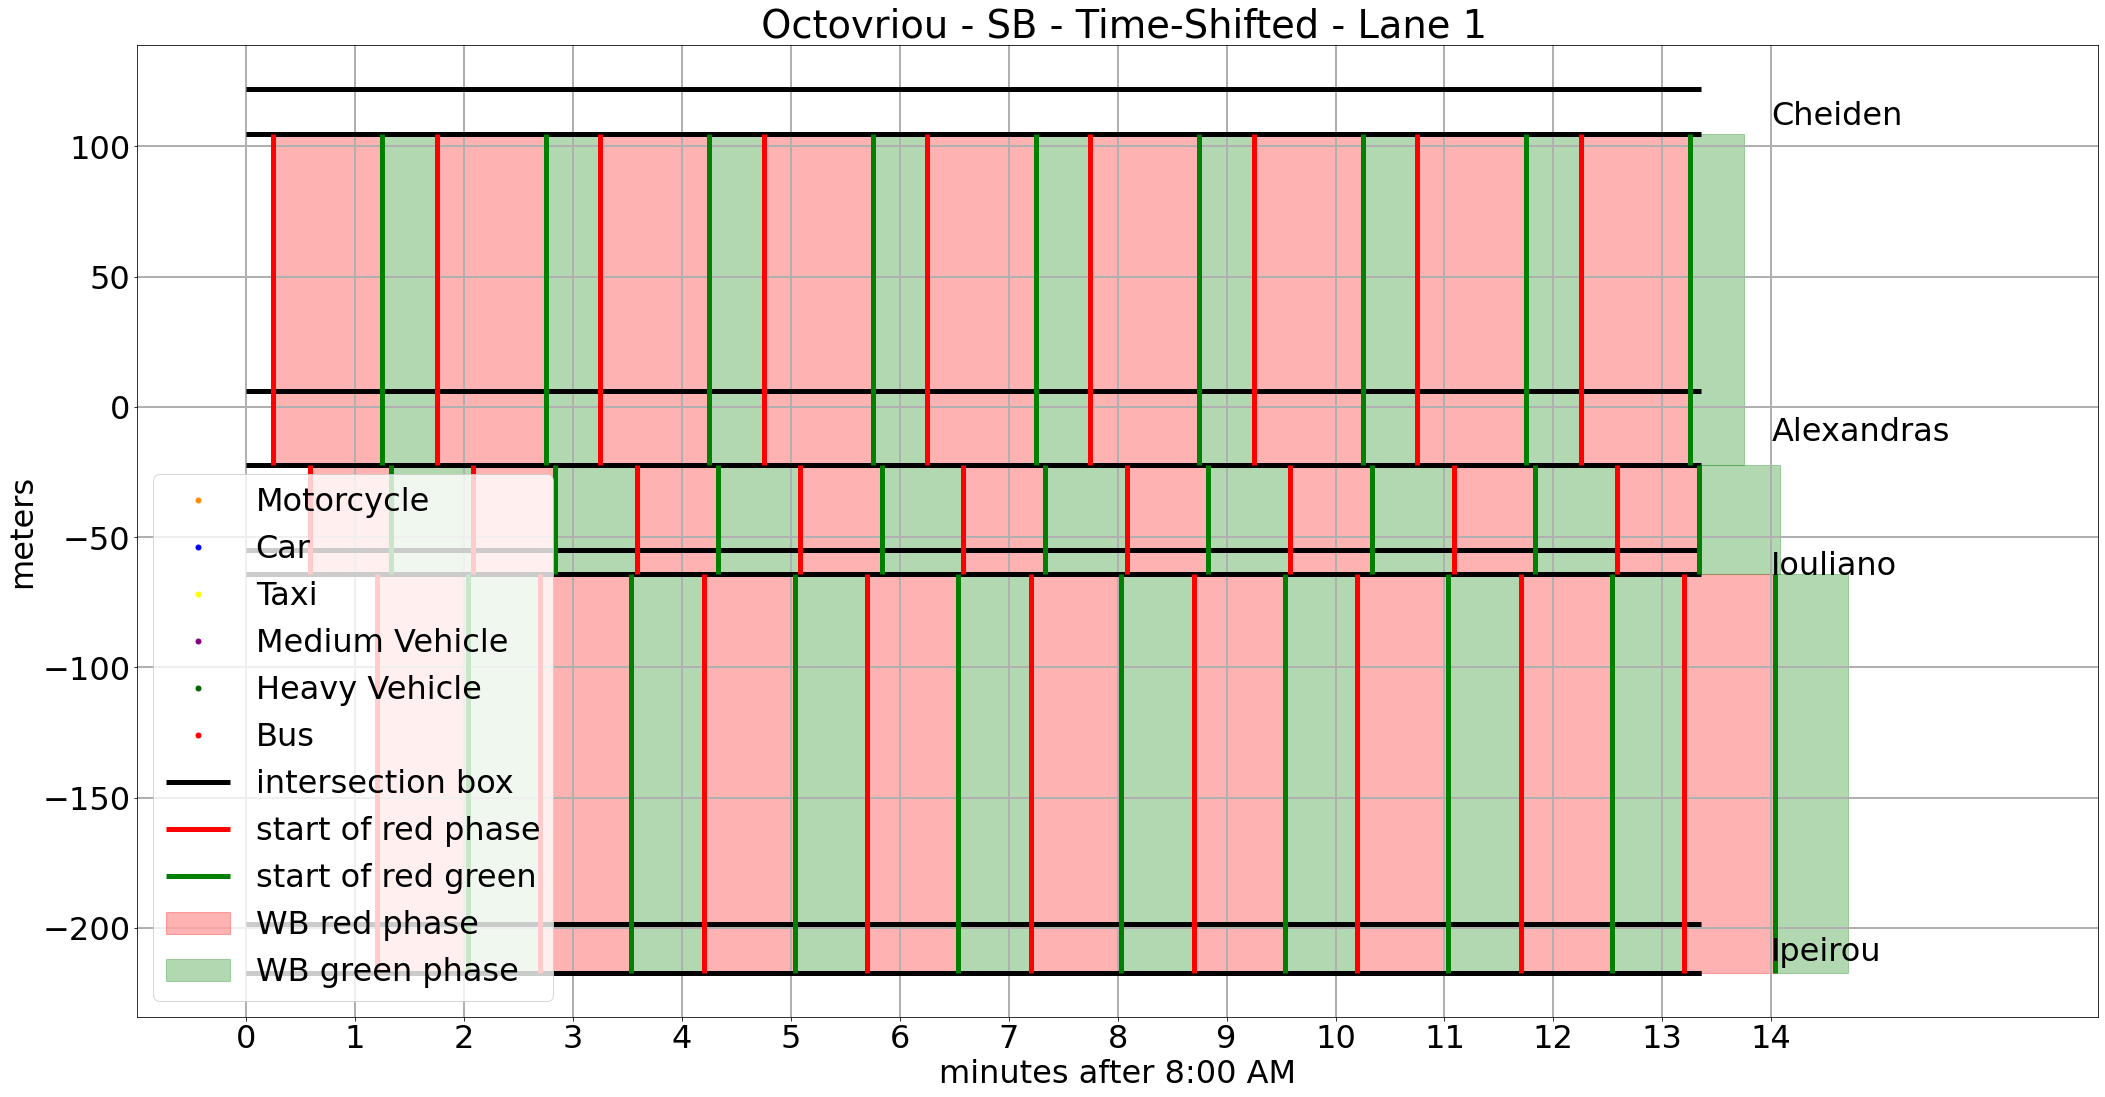

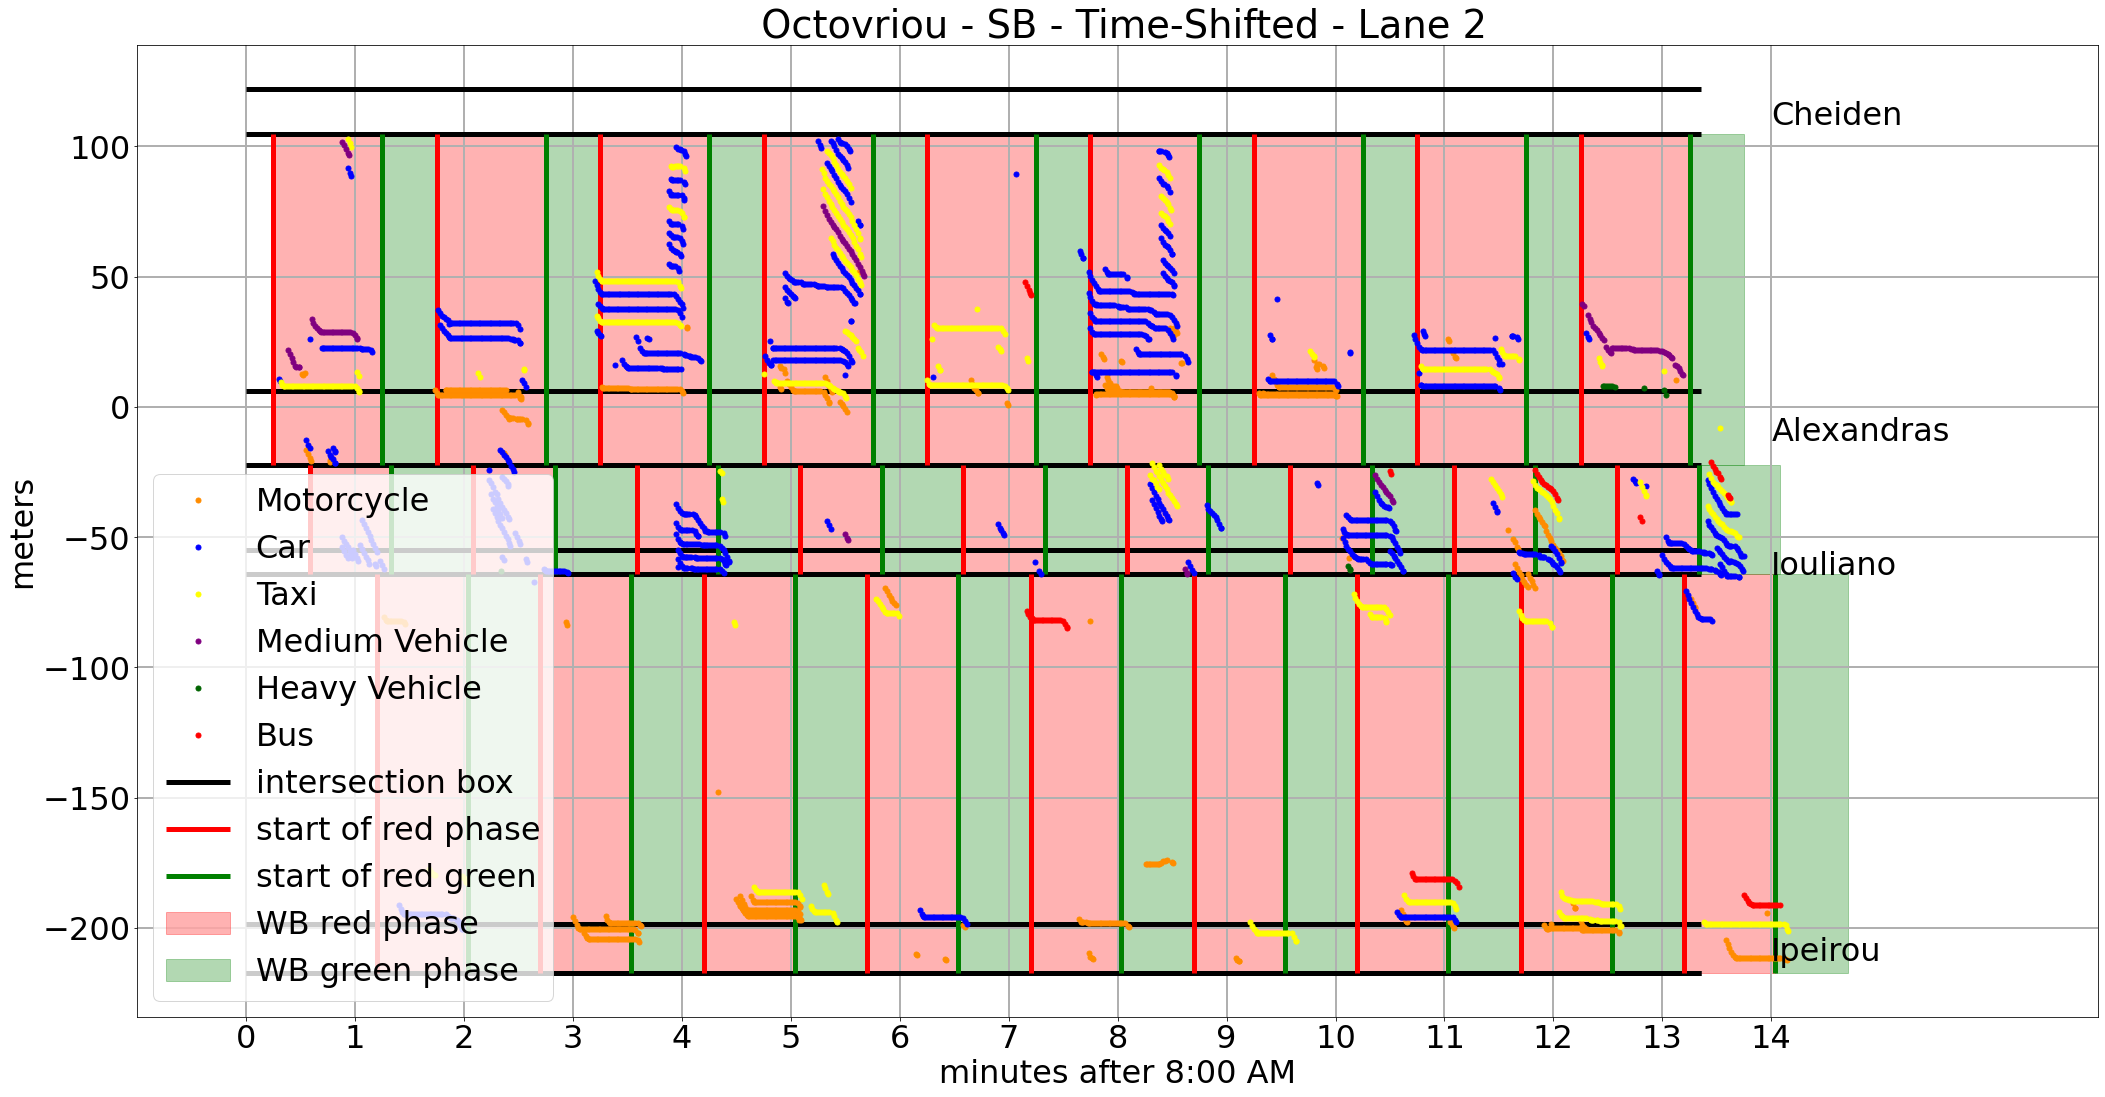

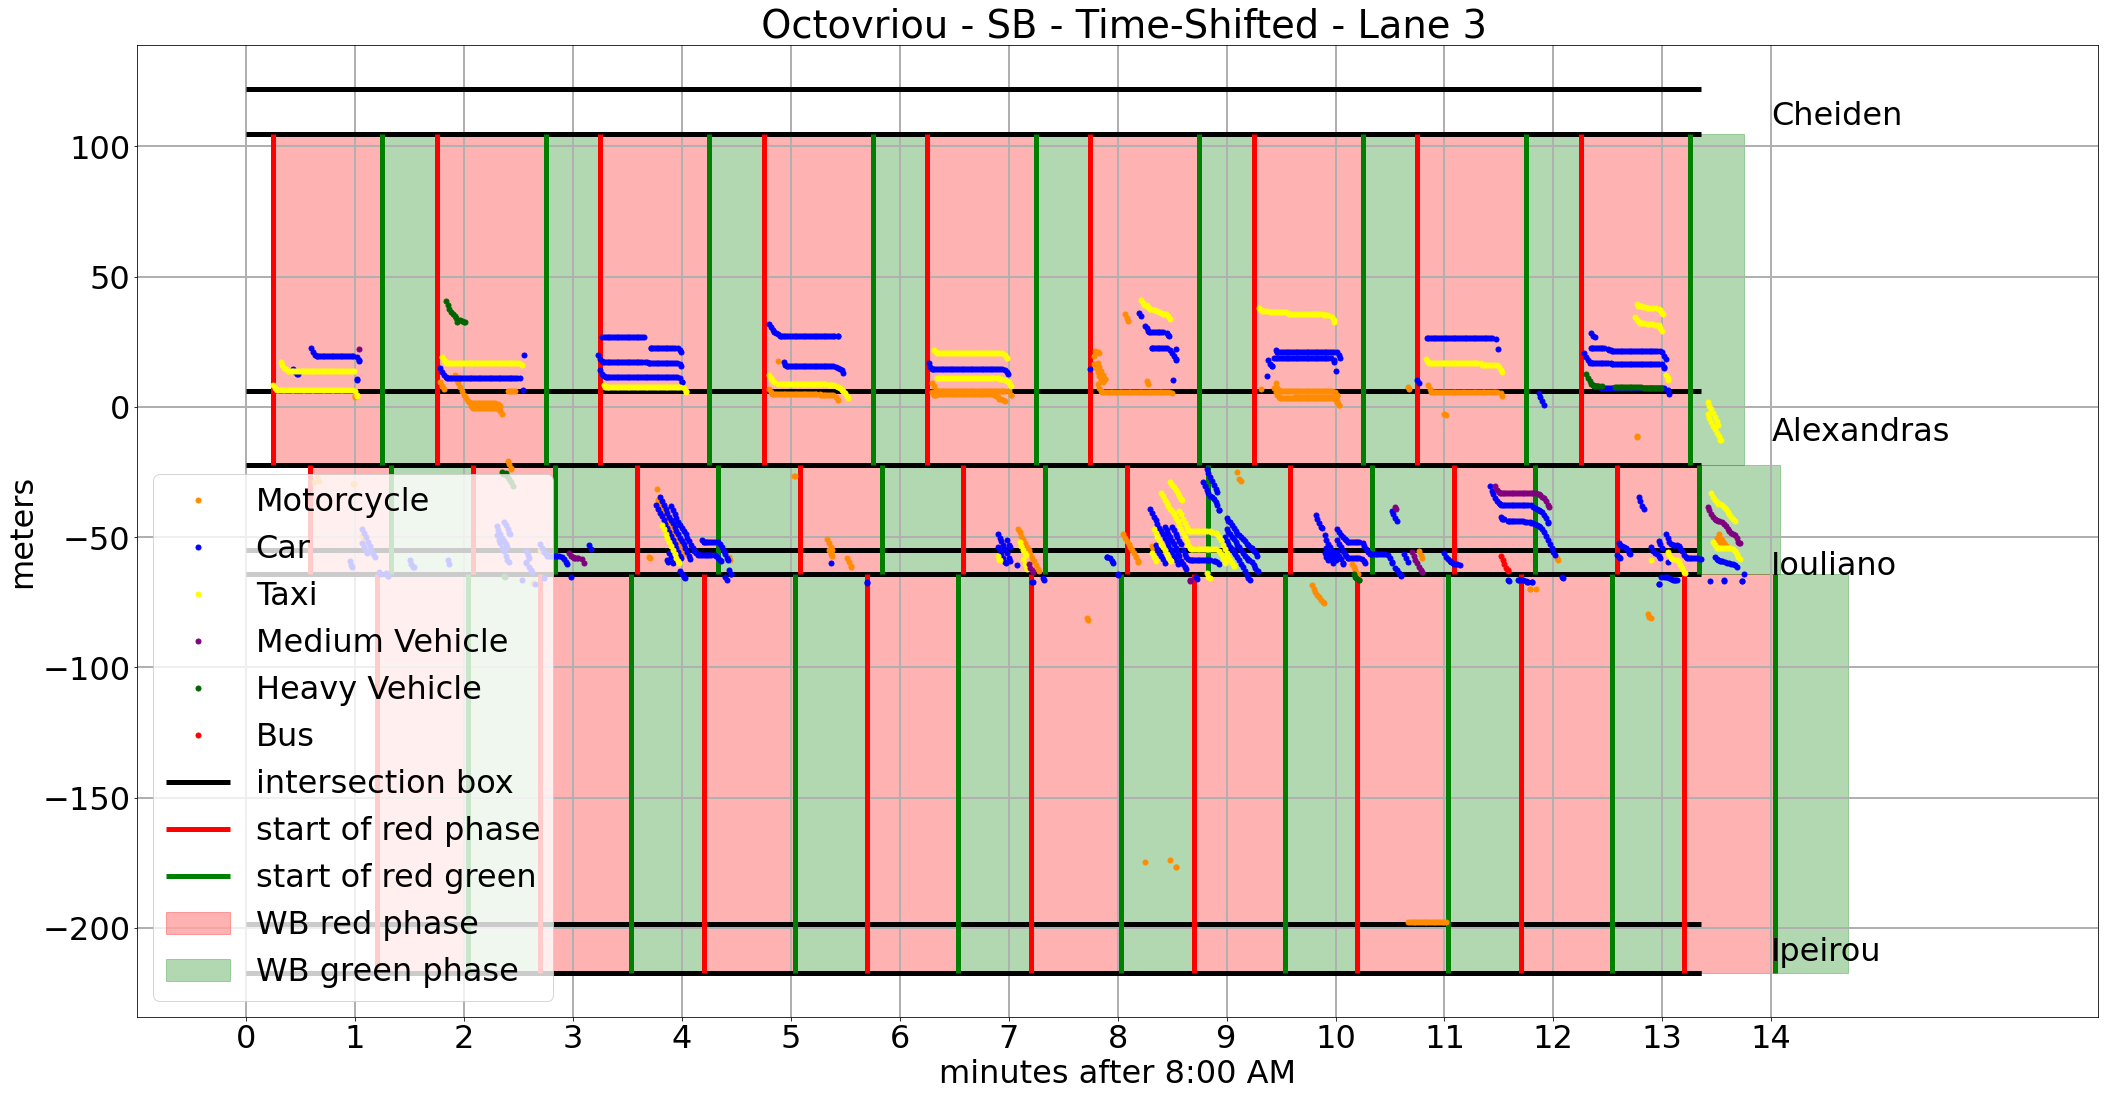

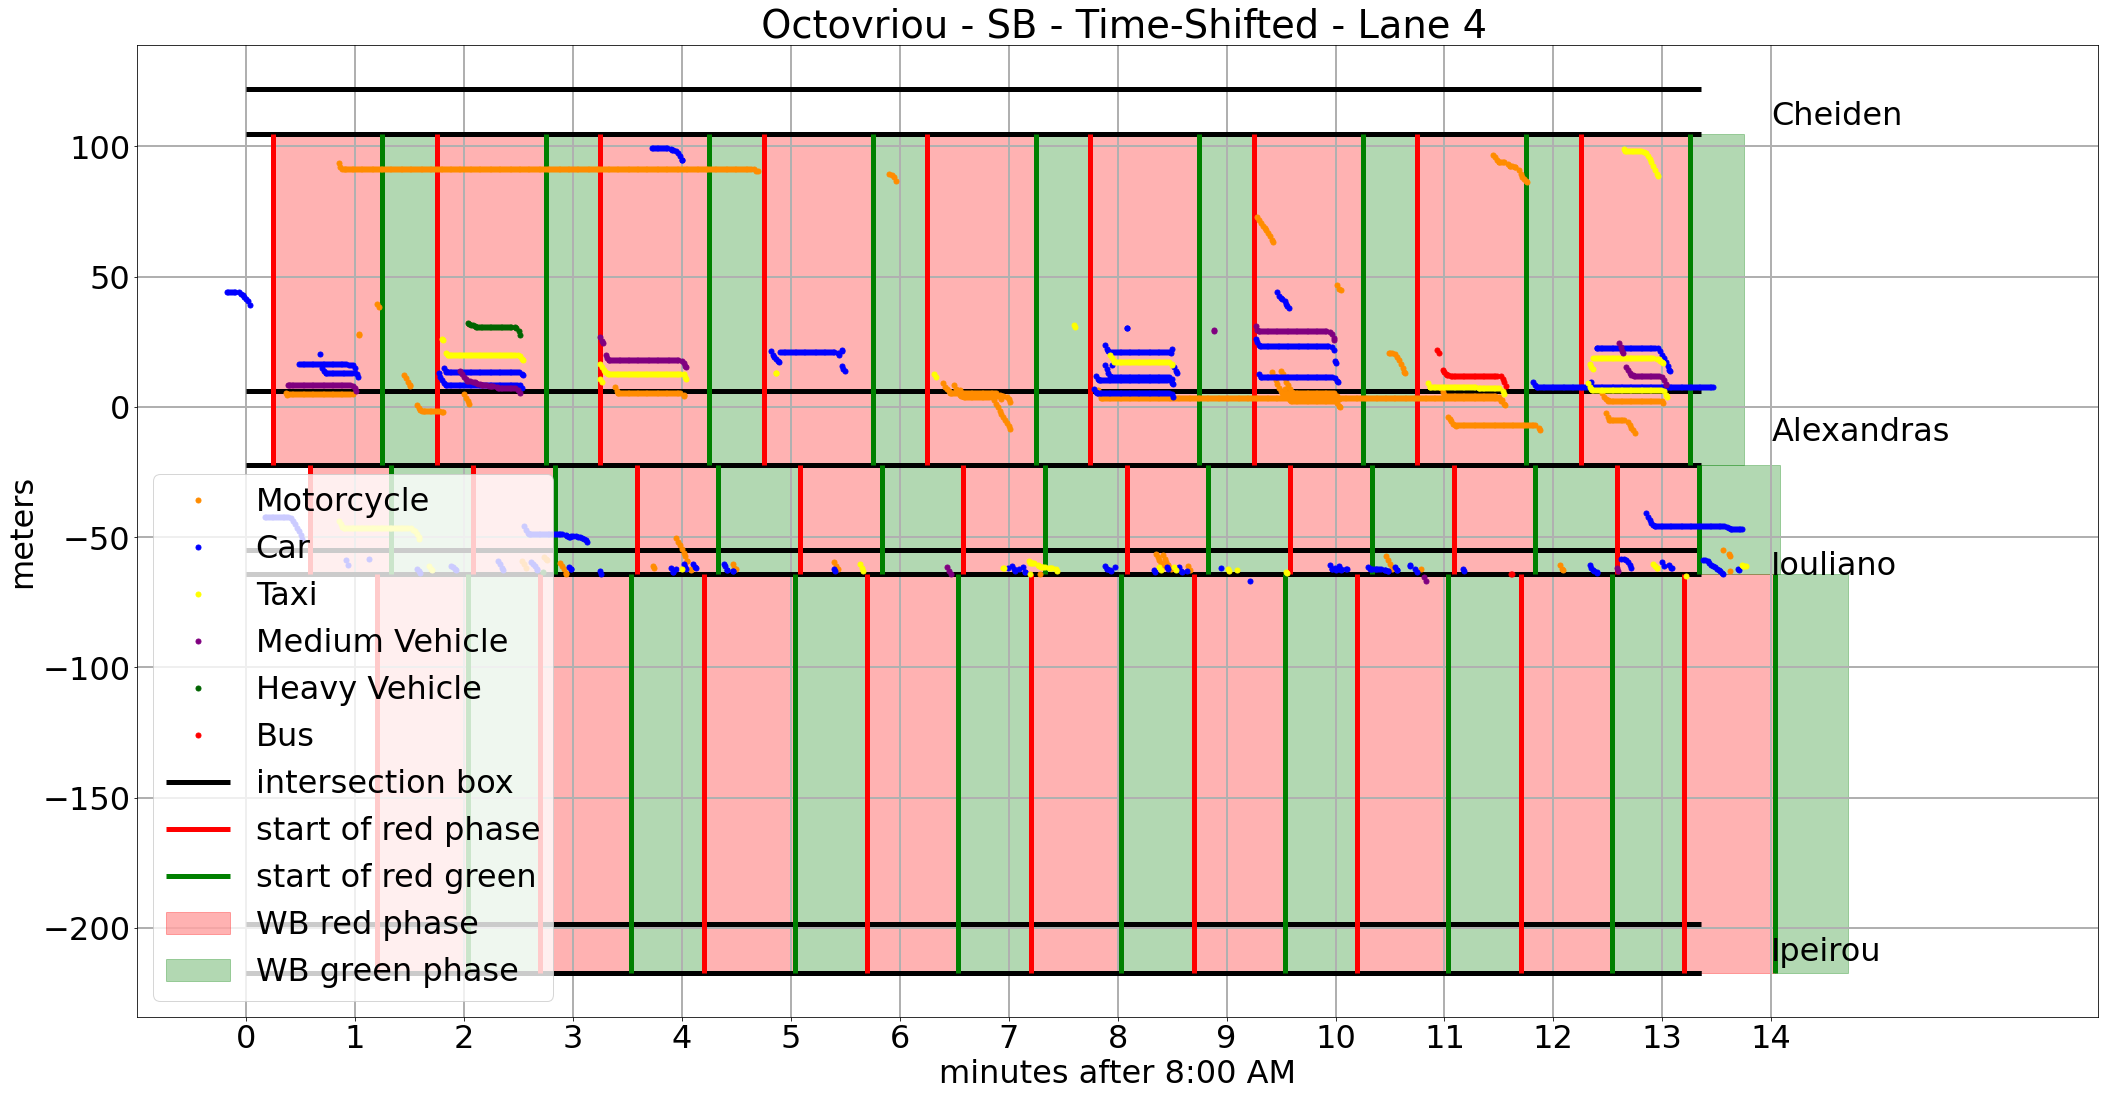

In [201]:
# set it to true/false it if LT lane (lane 1) is also included in the longest queue estimation
exclude_LT = True
# "intersections" includes (lat,lon) coordinates for each intersection on SB Octovriou 
# for each intersection it contains a point on the stop bar at the stop bars on the north side and south side of the intersection 
intersections = [(37.992898,23.731597), (37.992746, 23.731561), (37.991876,23.731356), (37.991637,23.731254), 
                 (37.991352, 23.731171), (37.991271, 23.731154), (37.990090,23.730867), (37.989926,23.730820)]
intersections_name = ['Ipeirou', 'Iouliano', 'Alexandras', 'Cheiden']
# load the heading angle of Octovrious from the second row of street_df and save it in "heading" 
heading =  street_df.loc[1,'heading']

# find the location of intersections along the road
intersections = intersections_transform(intersections, heading)
# inverse the order directions (the original order of corrdinates are in reverse order)
# subtract offset = 205 to make Alesandras intersection at X_road = 0
intersections = intersections[::-1] - 205

# select all vehicles that can be potentially part of a queue
stopped_df = select_stopped_vehicles('Oktovriou', 'SB',10)

# determine lanes
stopped_df['lane'] = np.nan
lane_borders = [2.5, 6, 9.5, 13, 20]
for i in np.arange(4):
    stopped_df.loc[(stopped_df['Y_road']>lane_borders[i])&(stopped_df['Y_road']<lane_borders[i+1]),'lane'] = i+1

# determine (time,location) pairs that corrosponds to the same wave of stopped cars propagating toward the intersection upstreatm
stopped_df = wave_time_delay(stopped_df,15)

#************************************#
if exclude_LT:
    stopped_df = stopped_df[stopped_df['lane']>1]

# find max queues and related information
stopped_df = find_max_Q(stopped_df)

# timing plan
timing = [pd.to_datetime('2020-08-04 08:01:12',format='%Y-%m-%d %H:%M:%S.%f'),
          pd.to_datetime('2020-08-04 08:00:35',format='%Y-%m-%d %H:%M:%S.%f'), 
          pd.to_datetime('2020-08-04 08:00:15',format='%Y-%m-%d %H:%M:%S.%f')]
red_phase = [50, 45, 60]

plot_queues(stopped_df, intersections, intersections_name, 'Octovriou - SB', timing, red_phase, use_tau= False, reverse_y = False)
plot_queues(stopped_df, intersections, intersections_name, 'Octovriou - SB - Time-Shifted', timing, red_phase, use_tau= True, reverse_y = False)


## Visualization

In [ ]:
from keplergl import KeplerGl

In [ ]:
sample_data = trace_df[#(trace_df['road'] == 'Oktovriou') & (trace_df['dir'] == 'SB') & 
                       (trace_df['time'] > '2020-08-04 08:9:20') & 
                       (trace_df['time'] < '2020-08-04 08:10:00') & 
                       (trace_df['X_road']<500)]
sample_data['type'] = np.nan
sample_data.loc[trace_df['track_id'].isin(motors), 'type'] = 'motor'
sample_data.loc[trace_df['track_id'].isin(cars), 'type'] = 'car'
sample_data.loc[trace_df['track_id'].isin(taxi), 'type'] = 'taxi'
sample_data.loc[trace_df['track_id'].isin(mediums), 'type'] = 'medium'
sample_data.loc[trace_df['track_id'].isin(heavy), 'type'] = 'heavy'
sample_data.loc[trace_df['track_id'].isin(bus), 'type'] = 'bus'
sample_data = sample_data[['track_id','lat','lon','time','type','X_road','Y_road','speed','roundad']]
sample_data['time'] = sample_data['time'].astype(str)

In [ ]:
#sample_data = trace_df#trace_df[trace_df['track_id']==1708]
map_1 = KeplerGl(height=800, data={'trips': sample_data})
map_1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002DDF7255E48>]],
      dtype=object)

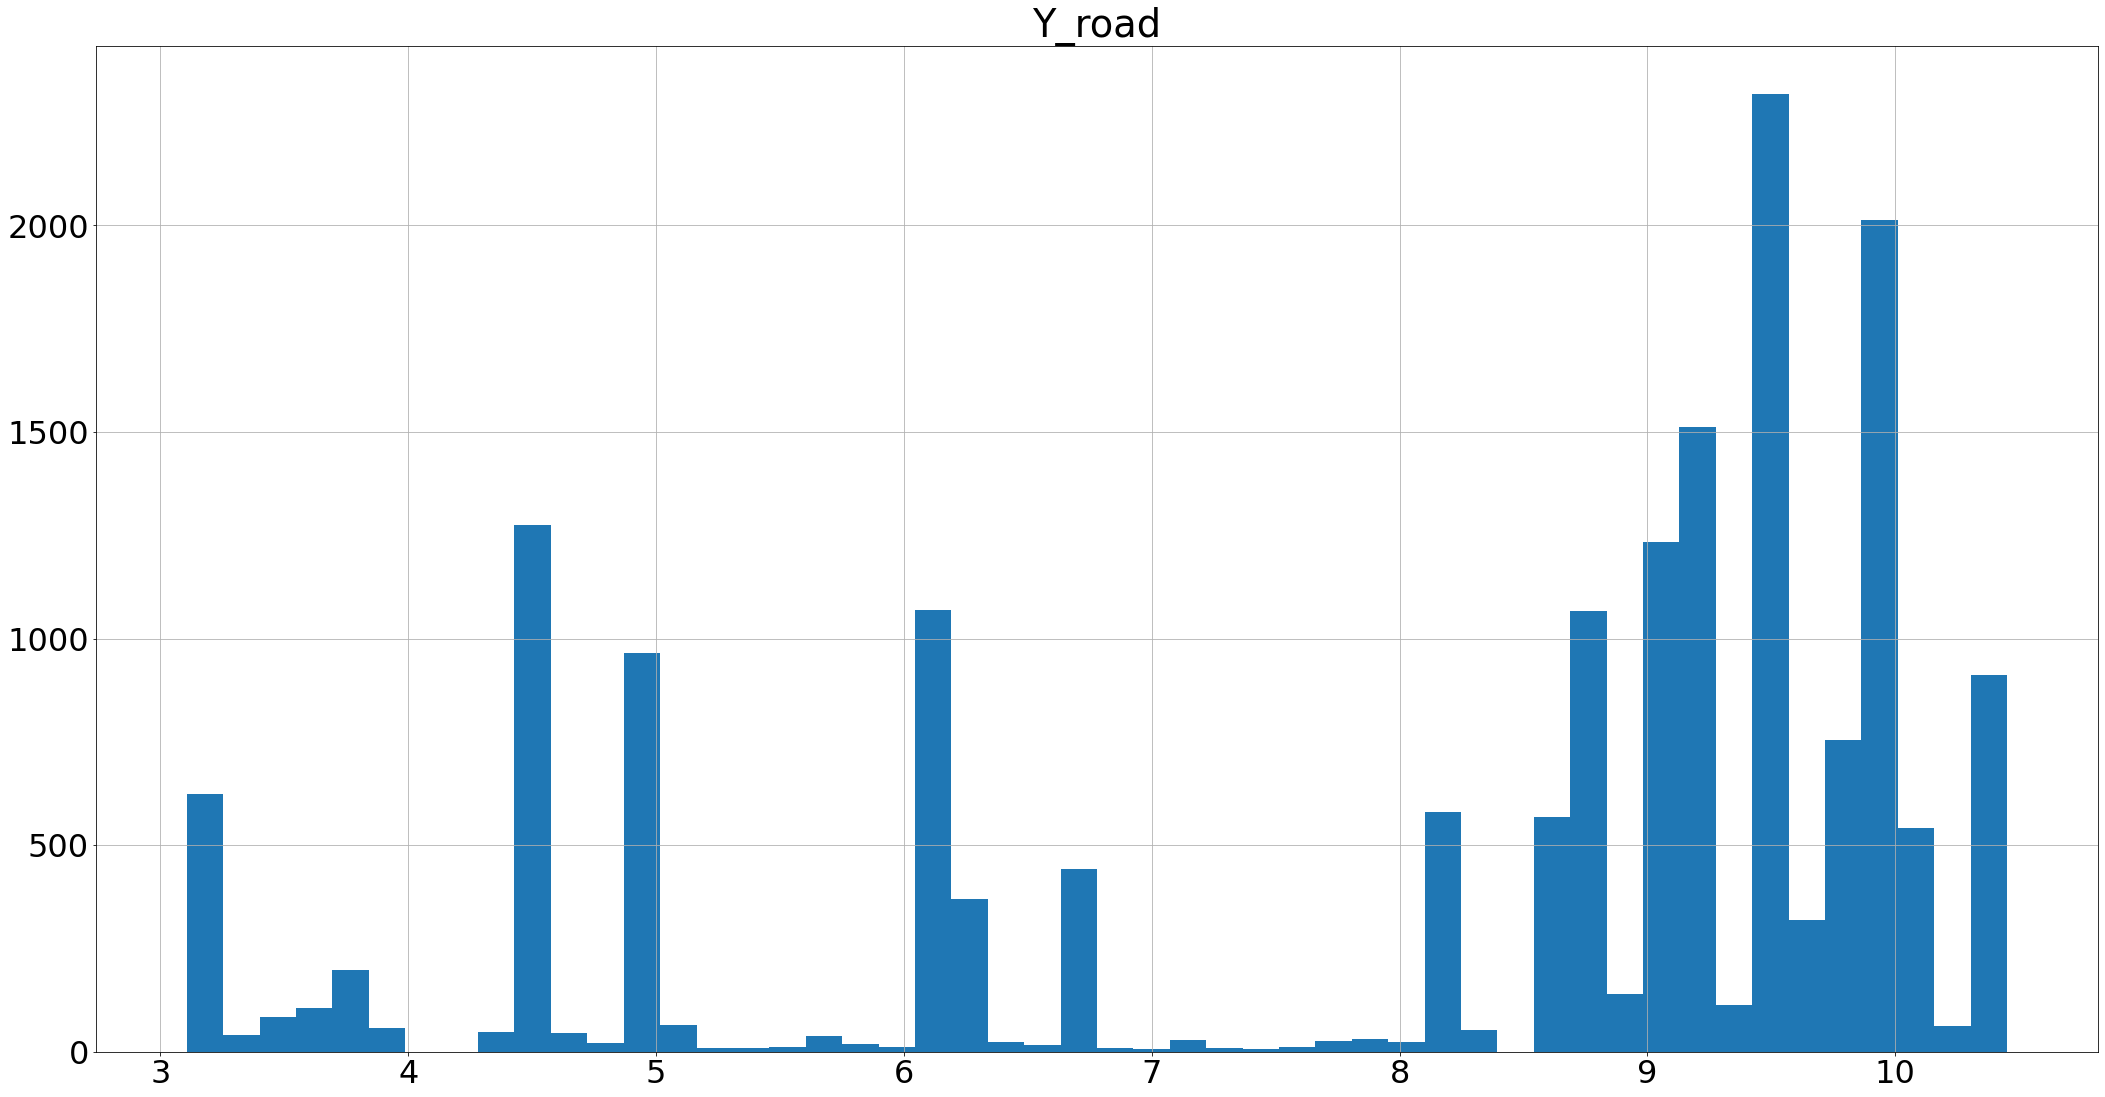

In [93]:
stopped_ramp_df[(stopped_ramp_df['X_road']>10)&(stopped_ramp_df['X_road']<30)].hist('Y_road',bins=50)